In [1]:
import pandas as pd
import numpy as np
import json

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

from utils import get_price, get_stables_mcap, get_staking_rewards, get_tvl, merge_df

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score

import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

In [2]:
tvl_data = ['data/algorand.csv', 'data/aptos.csv', 'data/cardano.csv', 'data/icp.csv', 
            'data/near.csv', 'data/solana.csv', 'data/sui.csv', 'data/tezos.csv']

price_data = ['price/algo_usd.csv', 'price/apt_usd.csv', 'price/ada_usd.csv', 'price/icp_usd.csv',
              'price/near_usd.csv', 'price/sol_usd.csv', 'price/sui_usd.csv', 'price/xtz_usd.csv']

stables_data = ['algorand.csv', 'aptos.csv', 'cardano.csv', 'icp.csv', 
                'near.csv', 'solana.csv', 'sui.csv', 'tezos.csv']


staking_data = ['algorand.json', 'aptos.json', 'cardano.json', 'icp.json',
                'near.json', 'solana.json', 'sui.json',  'tezos.json']

chain_names = ['Algorand', 'Aptos', 'Cardano', 'ICP', 
               'NEAR', 'Solana', 'Sui', 'Tezos']

In [3]:
interest_rates = pd.read_csv('inlfation/interest_rates.csv',header=None)
interest_rates.drop(0, axis=1, inplace=True)
interest_rates.columns = ['Date', 'InterestRate']

In [4]:
interest_rates['Date'] = pd.to_datetime(interest_rates['Date'])
interest_rates

Date  InterestRate
0   2022-05-12          0.83
1   2022-05-13          0.83
2   2022-05-14          0.83
3   2022-05-15          0.83
4   2022-05-16          0.83
..         ...           ...
858 2024-09-16          5.33
859 2024-09-17          5.33
860 2024-09-18          5.33
861 2024-09-19          4.83
862 2024-09-20          4.83

[863 rows x 2 columns]

In [5]:
tvl = get_tvl('Algorand', tvl_data[0])
price = get_price(price_data[0])
stable = get_stables_mcap(stables_data[0])
staking = get_staking_rewards(staking_data[0])

algorand = merge_df(tvl, price, stable, staking)
algorand = algorand.merge(interest_rates, left_on='Date', right_on='Date', how='left')
algorand.drop_duplicates(inplace=True)
algorand.reset_index(inplace=True, drop=True)


"""
algo_scaler = StandardScaler()
algorand[['TVL', 'price', 'market_cap', 
        'total_volume', 'StablesMCap', 'StakingRewards',
        'Liquidity']] = algo_scaler.fit_transform(algorand[['TVL', 'price', 'market_cap', 
                                    'total_volume', 'StablesMCap', 'StakingRewards',
                                    'Liquidity']])
"""
algorand.head()

Date           TVL     price    market_cap  total_volume  StablesMCap  \
0 2022-12-05  1.952681e+08  0.241424  1.723134e+09  4.228876e+07  312213478.0   
1 2022-12-06  1.925492e+08  0.237454  1.691877e+09  7.997809e+07  315170889.0   
2 2022-12-07  1.902759e+08  0.234740  1.669517e+09  4.845631e+07  314657387.0   
3 2022-12-08  1.838453e+08  0.222186  1.583133e+09  7.667316e+07  311356401.0   
4 2022-12-09  1.844228e+08  0.225350  1.606197e+09  5.591705e+07  312601361.0   

   StakingRewards  Liquidity  InterestRate  
0        7.363497   2.454177          3.83  
1        7.363655   4.727180          3.83  
2        7.367585   2.902414          3.83  
3        7.367823   4.843130          3.83  
4        7.367929   3.481332          3.83

Text(0.5, 1.0, 'Algorand 2024 Price Distribution')

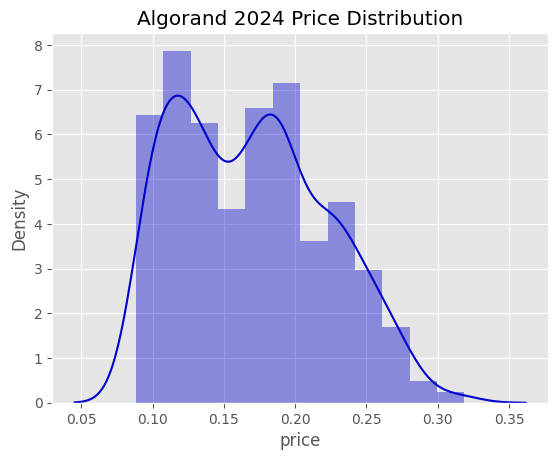

In [6]:
sns.distplot(algorand['price'], color='mediumblue')
plt.title('Algorand 2024 Price Distribution')

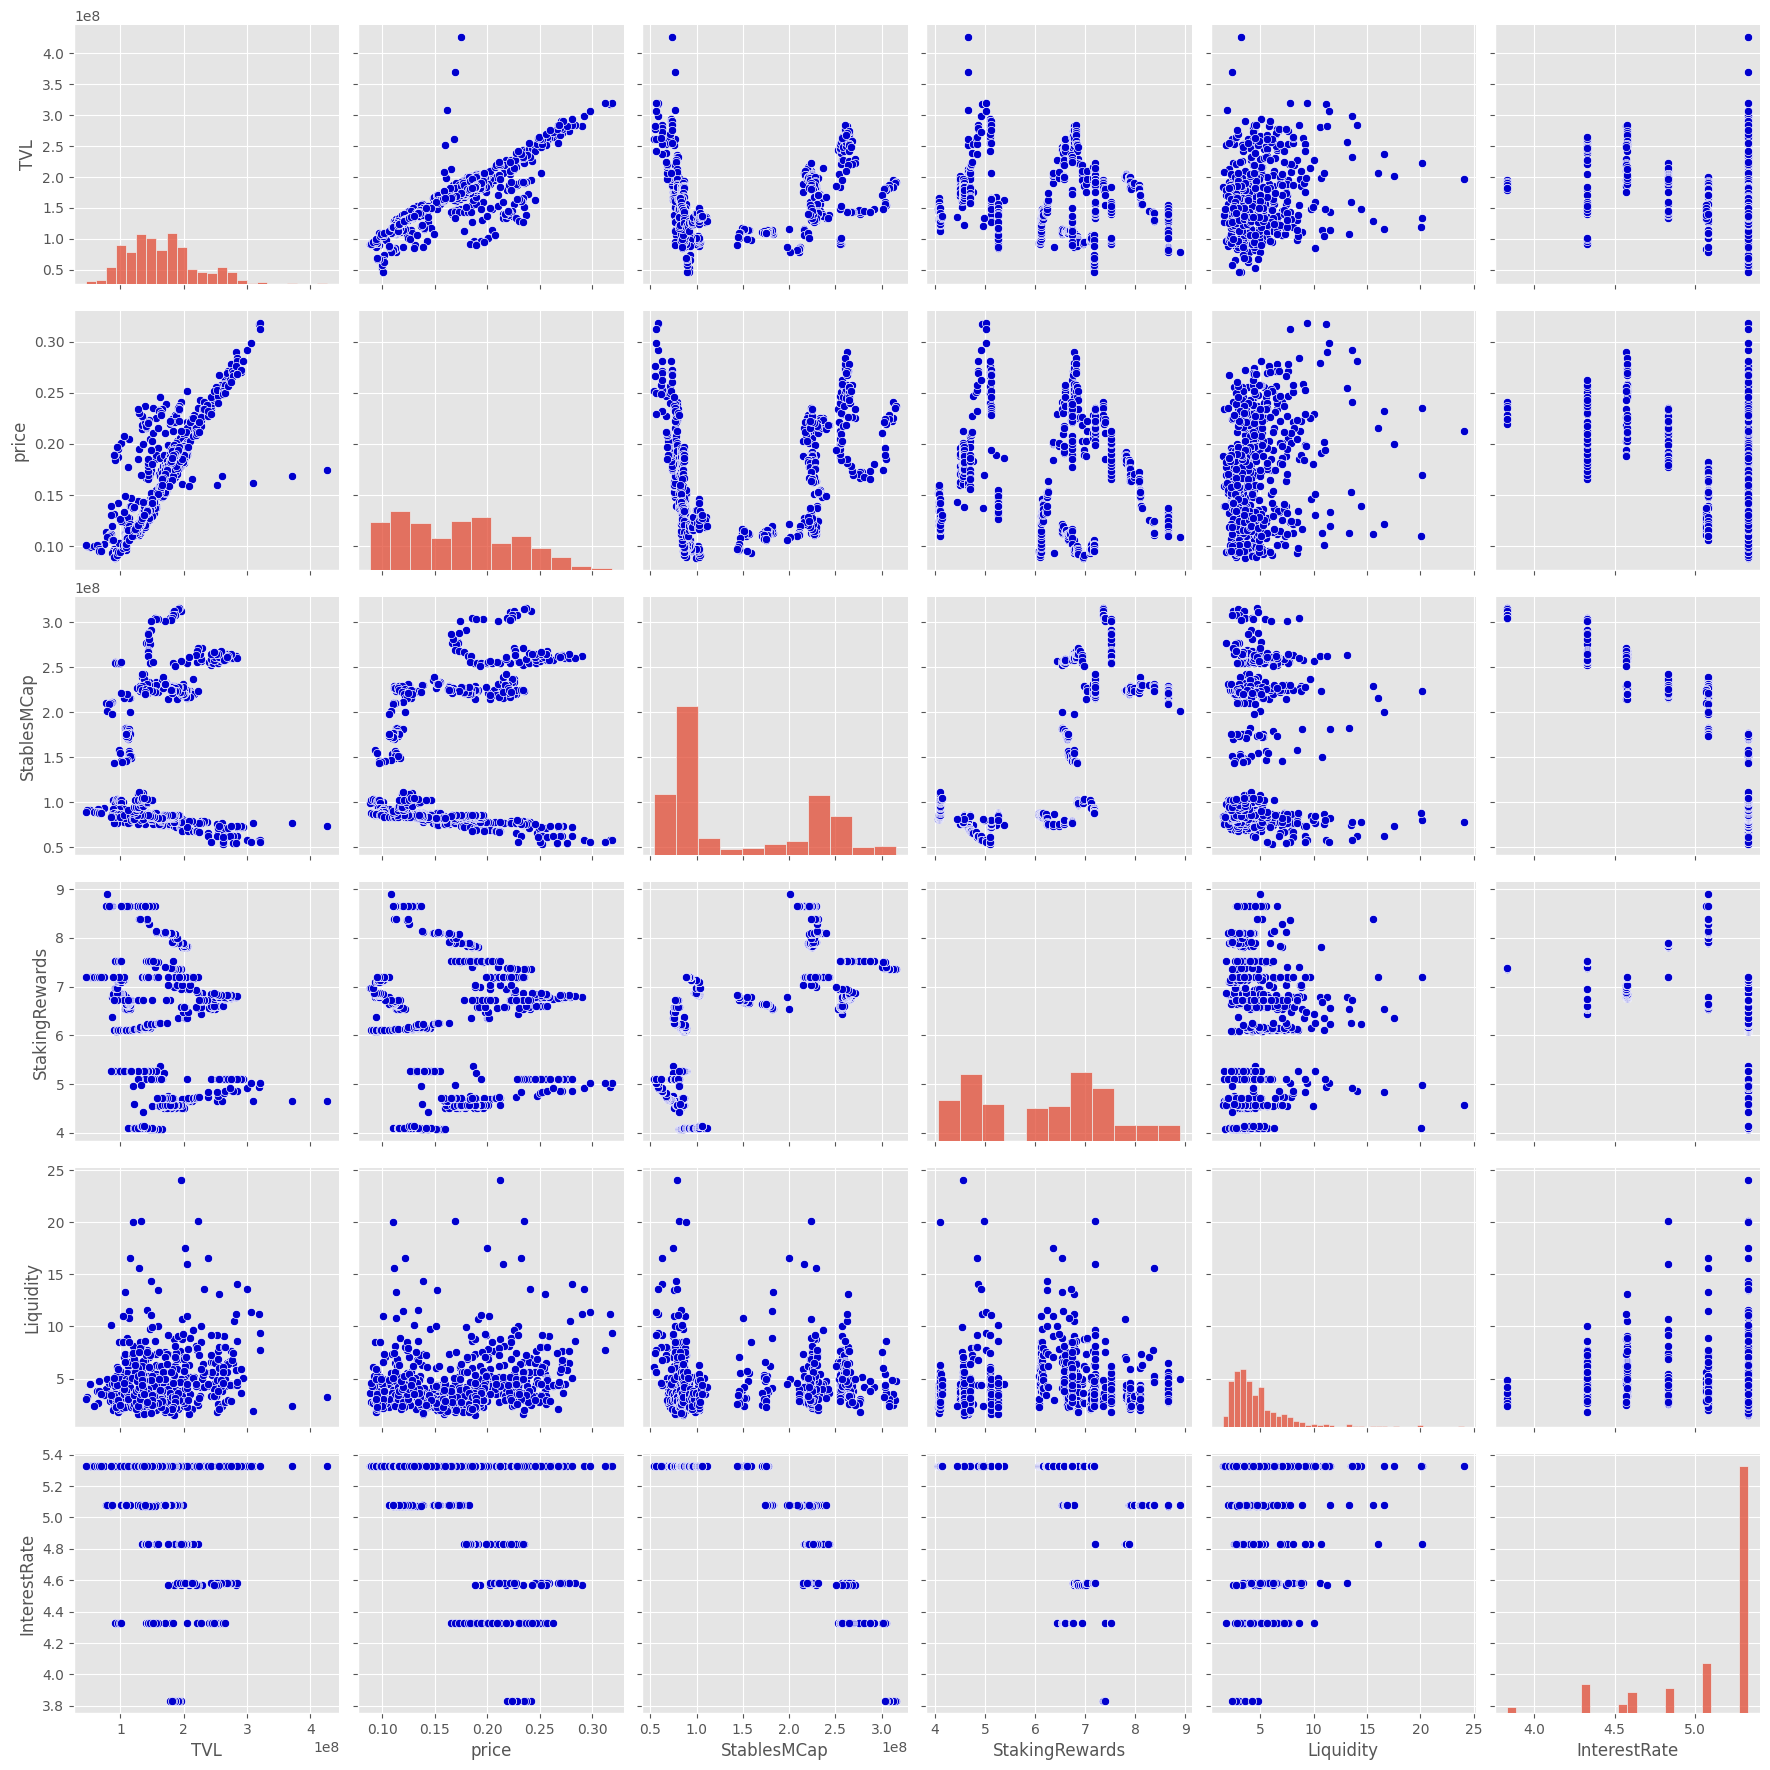

In [8]:
sns.pairplot(algorand[['TVL', 'price', 'StablesMCap', 'StakingRewards', 'Liquidity', 'InterestRate']], 
             height=3, aspect=1, 
             corner=False,
             plot_kws={'color': 'mediumblue'})
plt.show()

In [9]:
X = algorand[['TVL', 'StablesMCap', 'StakingRewards', 'Liquidity', 'InterestRate']]
y = algorand['price']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [10]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Predict on the test set
y_pred_linear = linear_model.predict(X_test)

# Calculate R^2 for the linear model
r2_linear = r2_score(y_test, y_pred_linear)
print(f'Linear Model R^2: {r2_linear:.2f}')

Linear Model R^2: 0.86


In [11]:
list(zip(X, linear_model.coef_)), linear_model.intercept_

([('TVL', 7.057998563699117e-10),
  ('StablesMCap', -2.7972438002470505e-10),
  ('StakingRewards', 0.0016799612878827502),
  ('Liquidity', 0.000569679488515433),
  ('InterestRate', -0.08243701213760429)],
 0.501894536342082)

In [12]:
# Create polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly_train = poly.fit_transform(X_train)
X_poly_test = poly.transform(X_test)

# Fit the polynomial regression model
poly_model = LinearRegression()
poly_model.fit(X_poly_train, y_train)

# Predict on the test set
y_pred_poly = poly_model.predict(X_poly_test)

# Calculate R^2 for the polynomial model
r2_poly = r2_score(y_test, y_pred_poly)
print(f'Polynomial Model R^2: {r2_poly:.2f}')


Polynomial Model R^2: 0.86


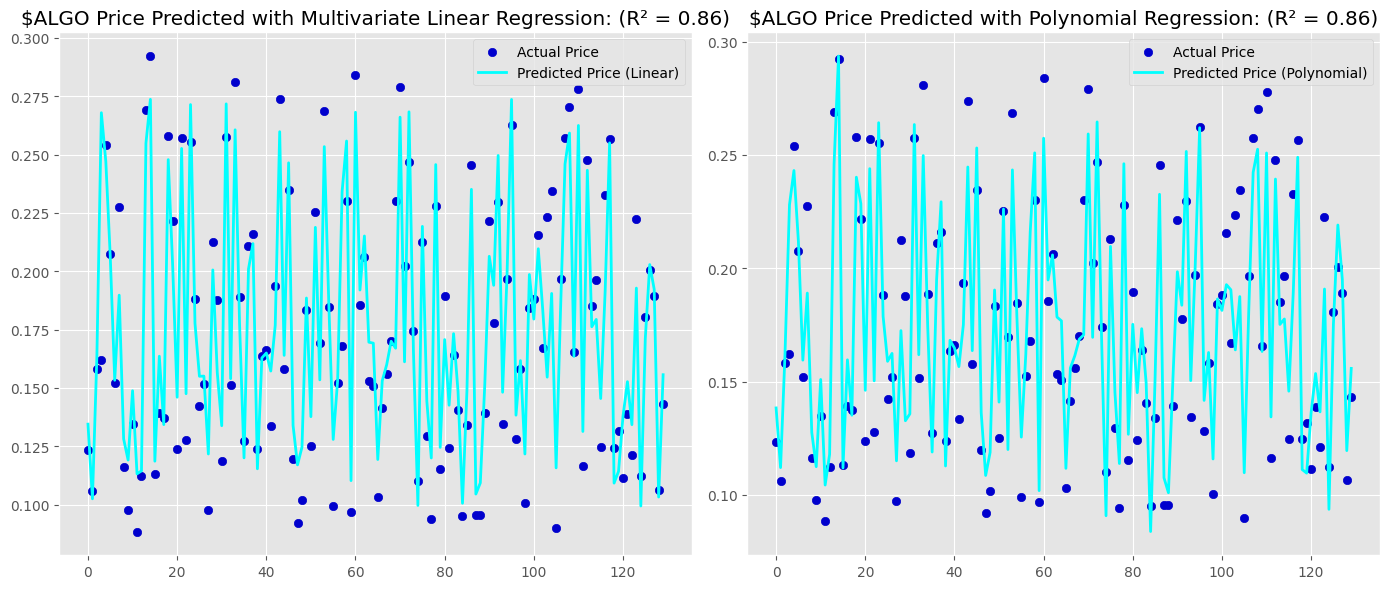

In [13]:
# Scatter plots and regression lines for the full set of variables
plt.figure(figsize=(14, 6))

# Scatter Plot of Actual vs Predicted for Linear Model
plt.subplot(1, 2, 1)
plt.scatter(range(len(y_test)), y_test, color='mediumblue', label='Actual Price')
plt.plot(range(len(y_pred_linear)), y_pred_linear, color='cyan', label='Predicted Price (Linear)', linewidth=2)
plt.title(f'$ALGO Price Predicted with Multivariate Linear Regression: (R² = {r2_linear:.2f})')
plt.legend()

# Scatter Plot of Actual vs Predicted for Polynomial Model
plt.subplot(1, 2, 2)
plt.scatter(range(len(y_test)), y_test, color='mediumblue', label='Actual Price')
plt.plot(range(len(y_pred_poly)), y_pred_poly, color='cyan', label='Predicted Price (Polynomial)', linewidth=2)
plt.title(f'$ALGO Price Predicted with Polynomial Regression: (R² = {r2_poly:.2f})')
plt.legend()

plt.tight_layout()
plt.show()

Subset Linear Model R^2: 0.31
Subset Polynomial Model R^2: 0.44


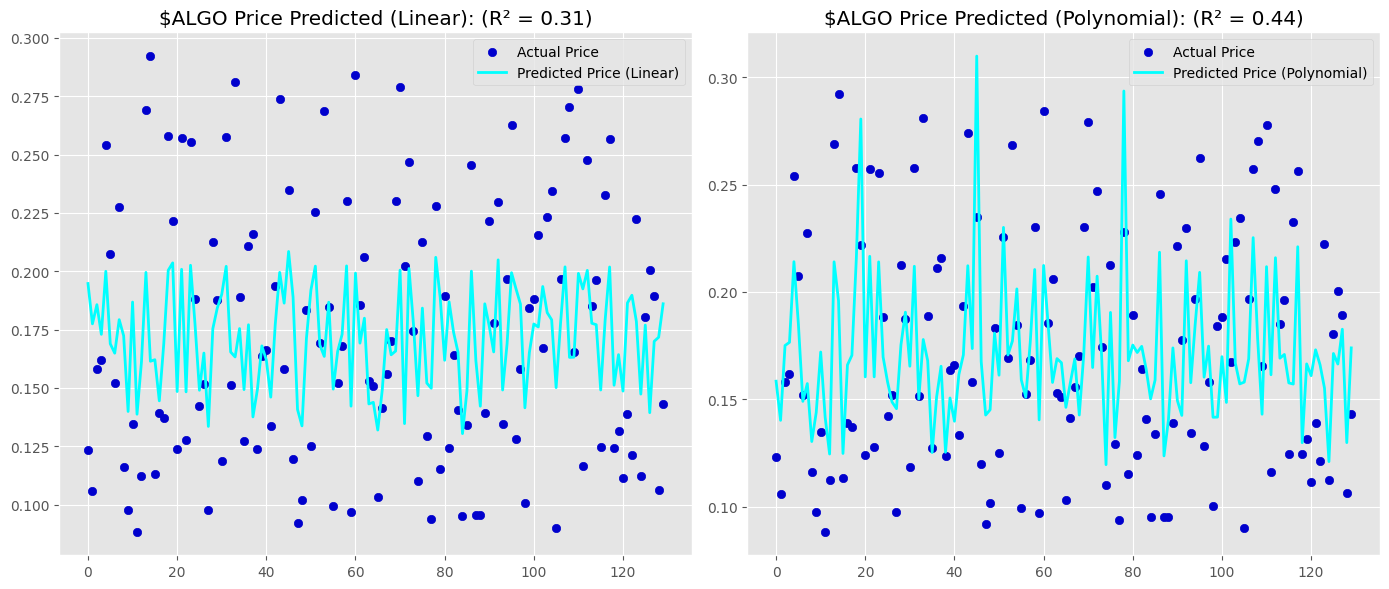

In [14]:
# Using only 'StablesMCap' and 'StakingRewards'
X_subset = algorand[['StablesMCap', 'StakingRewards']]
X_train_subset, X_test_subset, y_train_subset, y_test_subset = train_test_split(X_subset, y, test_size=0.2, random_state=42)

# Linear Regression on subset
linear_model_subset = LinearRegression()
linear_model_subset.fit(X_train_subset, y_train_subset)
y_pred_linear_subset = linear_model_subset.predict(X_test_subset)
r2_linear_subset = r2_score(y_test_subset, y_pred_linear_subset)
print(f'Subset Linear Model R^2: {r2_linear_subset:.2f}')

# Polynomial Regression on subset
X_poly_train_subset = poly.fit_transform(X_train_subset)
X_poly_test_subset = poly.transform(X_test_subset)

poly_model_subset = LinearRegression()
poly_model_subset.fit(X_poly_train_subset, y_train_subset)
y_pred_poly_subset = poly_model_subset.predict(X_poly_test_subset)
r2_poly_subset = r2_score(y_test_subset, y_pred_poly_subset)
print(f'Subset Polynomial Model R^2: {r2_poly_subset:.2f}')

# Scatter plots and regression lines for the subset of variables
plt.figure(figsize=(14, 6))

# Scatter Plot of Actual vs Predicted for Linear Model with Subset
plt.subplot(1, 2, 1)
plt.scatter(range(len(y_test_subset)), y_test_subset, color='mediumblue', label='Actual Price')
plt.plot(range(len(y_pred_linear_subset)), y_pred_linear_subset, color='cyan', label='Predicted Price (Linear)', linewidth=2)
plt.title(f'$ALGO Price Predicted (Linear): (R² = {r2_linear_subset:.2f})')
plt.legend()

# Scatter Plot of Actual vs Predicted for Polynomial Model with Subset
plt.subplot(1, 2, 2)
plt.scatter(range(len(y_test_subset)), y_test_subset, color='mediumblue', label='Actual Price')
plt.plot(range(len(y_pred_poly_subset)), y_pred_poly_subset, color='cyan', label='Predicted Price (Polynomial)', linewidth=2)
plt.title(f'$ALGO Price Predicted (Polynomial): (R² = {r2_poly_subset:.2f})')
plt.legend()

plt.tight_layout()
plt.show()

In [15]:
def fit_linear_model(X_train, y_train):
    # Fit the linear regression model
    linear_model = LinearRegression()
    linear_model.fit(X_train, y_train)
    return linear_model

def fit_polynomial_model(X_train, y_train, degree=2):
    # Transform features to polynomial features
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    X_poly_train = poly.fit_transform(X_train)
    
    # Fit the polynomial regression model
    poly_model = LinearRegression()
    poly_model.fit(X_poly_train, y_train)
    return poly_model, poly

def plot_regression_line(ax, X_test, y_test, y_pred, title, label='Linear'):
    # Scatter plot of actual values
    ax.scatter(range(len(y_test)), y_test, color='mediumblue', label='Actual Price')
    
    # Plot regression line
    ax.plot(range(len(y_pred)), y_pred, color='cyan', label=f'Predicted Price ({label})', linewidth=2)
    
    # Set title and legend
    ax.set_title(title)
    ax.legend()
    
    ax.set_xlabel('Index')  # You can also use 'Sample' if that fits better
    ax.set_ylabel('Price')




In [16]:
datasets = {}

for token in chain_names:
    file_idx = chain_names.index(token)
    tvl = get_tvl(token, tvl_data[file_idx])
    price = get_price(price_data[file_idx])
    stable = get_stables_mcap(stables_data[file_idx])
    staking = get_staking_rewards(staking_data[file_idx])
    final_df = merge_df(tvl, price, stable, staking)
    final_df = final_df.merge(interest_rates, left_on='Date', right_on='Date', how='left')
    final_df.drop_duplicates(inplace=True)
    final_df.reset_index(inplace=True, drop=True)
    datasets[token] = final_df

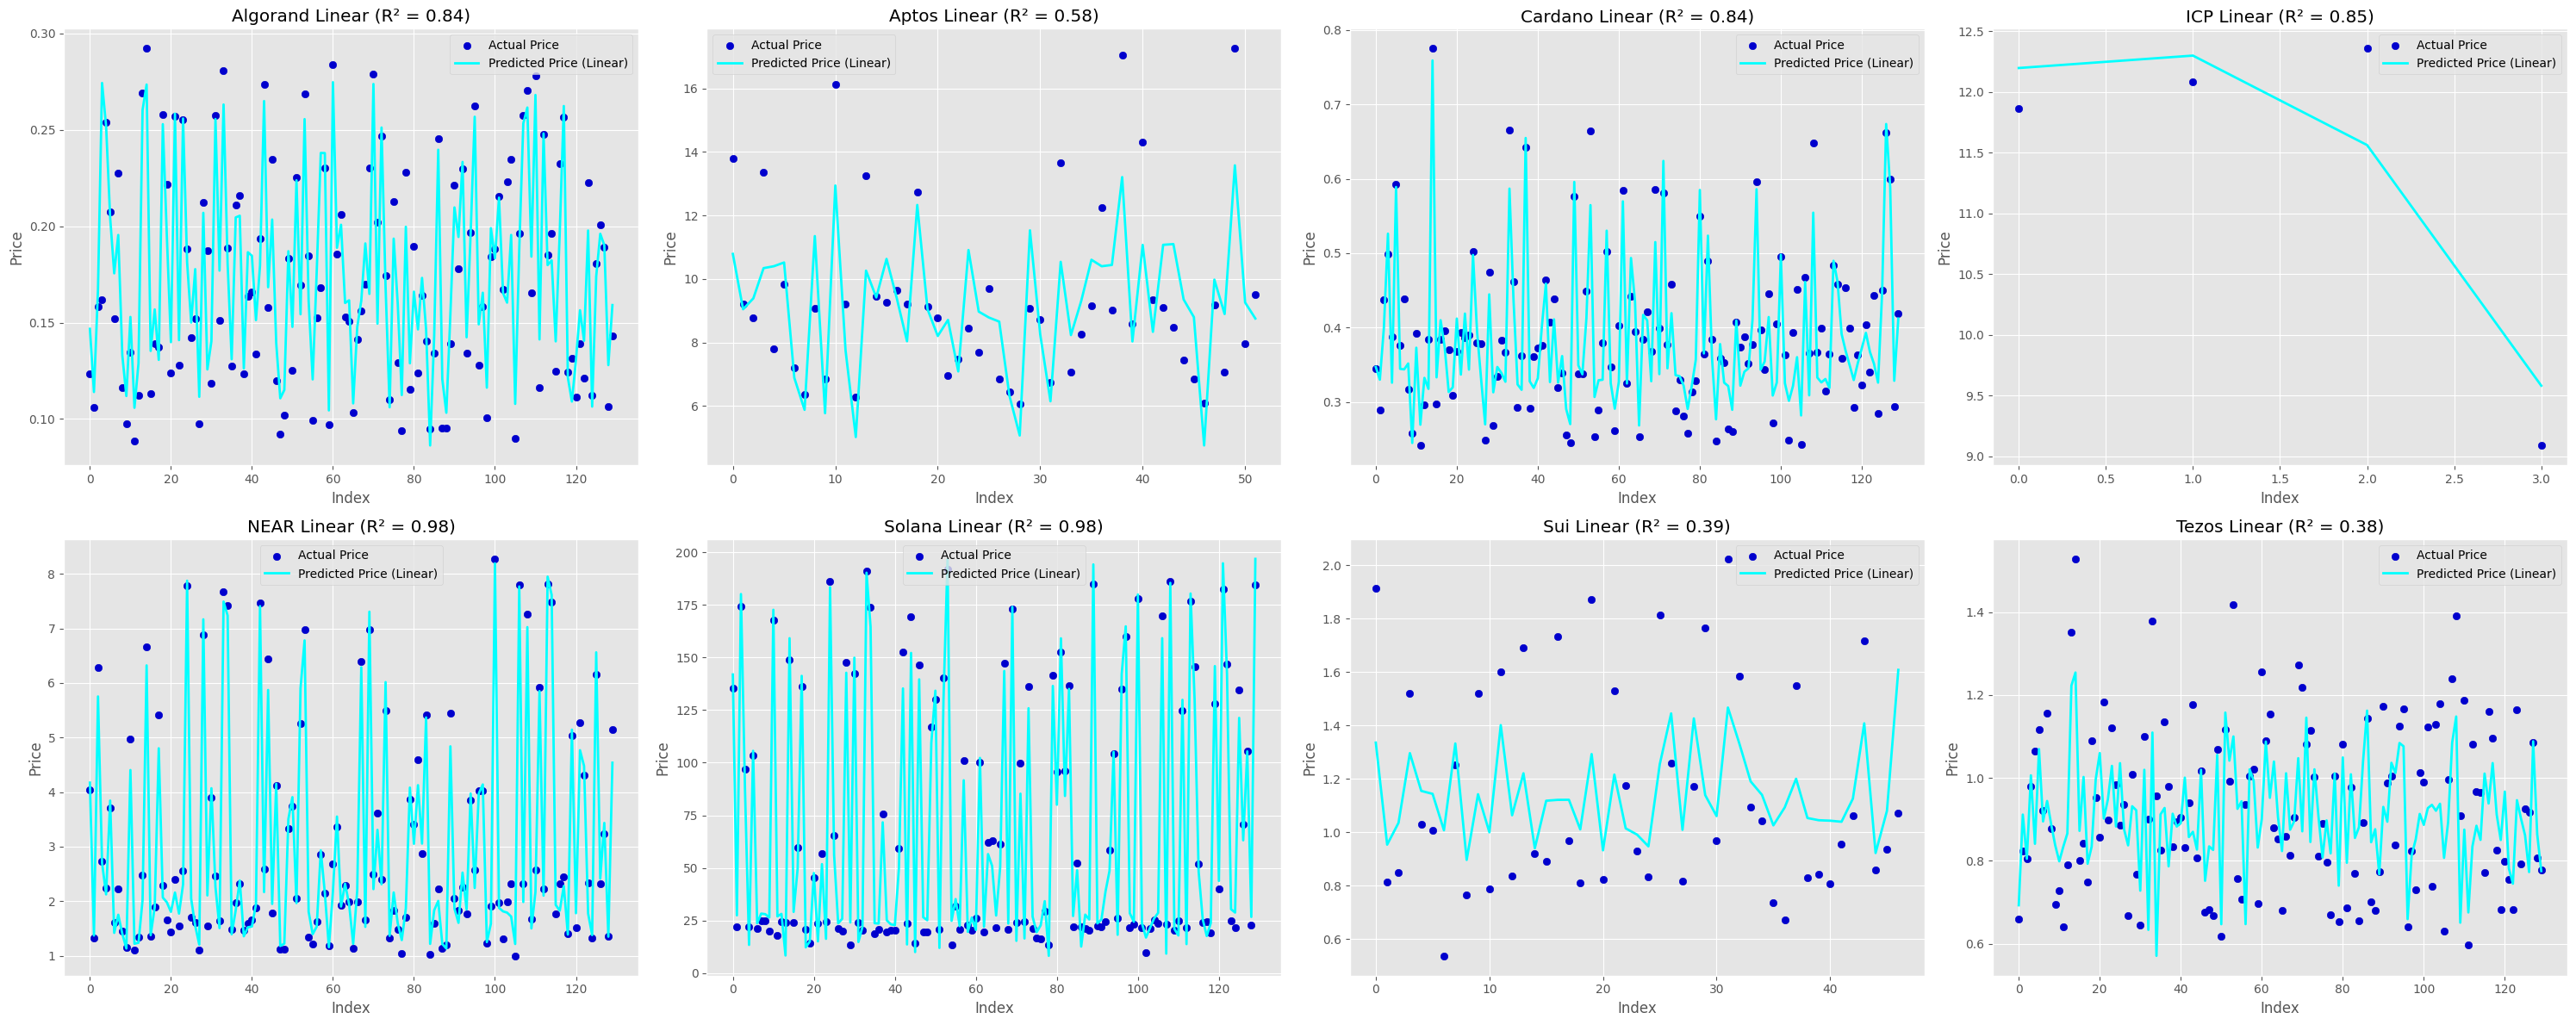

Equation for Algorand: Equation for Algorand (Linear): y = 1.69e-01 + 4.10e-02 * x_1 + 8.73e-03 * x_2 + -4.26e-03 * x_3 + 2.06e-03 * x_4
Equation for Aptos: Equation for Aptos (Linear): y = 8.98e+00 + 3.71e+00 * x_1 + -4.86e+00 * x_2 + 7.26e-04 * x_3 + 1.13e-01 * x_4
Equation for Cardano: Equation for Cardano (Linear): y = 4.00e-01 + 1.68e-01 * x_1 + -6.15e-02 * x_2 + 1.71e-02 * x_3 + 2.91e-03 * x_4
Equation for ICP: Equation for ICP (Linear): y = 1.09e+01 + 5.51e-01 * x_1 + -3.93e-01 * x_2 + -1.30e-01 * x_3 + -1.38e-01 * x_4
Equation for NEAR: Equation for NEAR (Linear): y = 3.13e+00 + 2.26e+00 * x_1 + -4.23e-01 * x_2 + 1.59e-01 * x_3 + 6.70e-02 * x_4
Equation for Solana: Equation for Solana (Linear): y = 7.40e+01 + 7.57e+01 * x_1 + -1.77e+01 * x_2 + 1.98e+00 * x_3 + 2.38e+00 * x_4
Equation for Sui: Equation for Sui (Linear): y = 1.18e+00 + 4.54e-02 * x_1 + 5.54e-02 * x_2 + 2.16e-01 * x_3 + 1.12e-01 * x_4
Equation for Tezos: Equation for Tezos (Linear): y = 9.15e-01 + 9.28e-02 * x_1 +

In [17]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(30, 12))
axes = axes.flatten()

equations = []
scalers = {}
for i, token in enumerate(chain_names):
    # Extract features and target
    df = datasets[token]
    df = df[df['StablesMCap'].notna()]
    df = df[df['StakingRewards'].notna()]

    

    X = df[['TVL', 'StablesMCap', 'StakingRewards', 'Liquidity']]
    y = df['price']

    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)

    scalers[token] = scaler

    # Fit linear regression model
    linear_model = fit_linear_model(X_train, y_train)
    y_pred_linear = linear_model.predict(scaler.transform(X_test))
    r2_linear = r2_score(y_test, y_pred_linear)
    
    # Get the coefficients and intercept in scientific notation for linear model
    coeffs = linear_model.coef_
    intercept = linear_model.intercept_
    equation_linear = f'y = {intercept:.2e}'
    for j, coef in enumerate(coeffs):
        equation_linear += f' + {coef:.2e} * x_{j+1}'
    
    # Store equation for linear model
    equations.append(f'Equation for {token} (Linear): {equation_linear}')



    # Plot linear regression
    plot_regression_line(axes[i], X_test, y_test, y_pred_linear, 
                         f'{token} Linear (R² = {r2_linear:.2f})', label='Linear')

plt.tight_layout()
plt.show()

for token, equation in zip(chain_names, equations):
    print(f'Equation for {token}: {equation}')

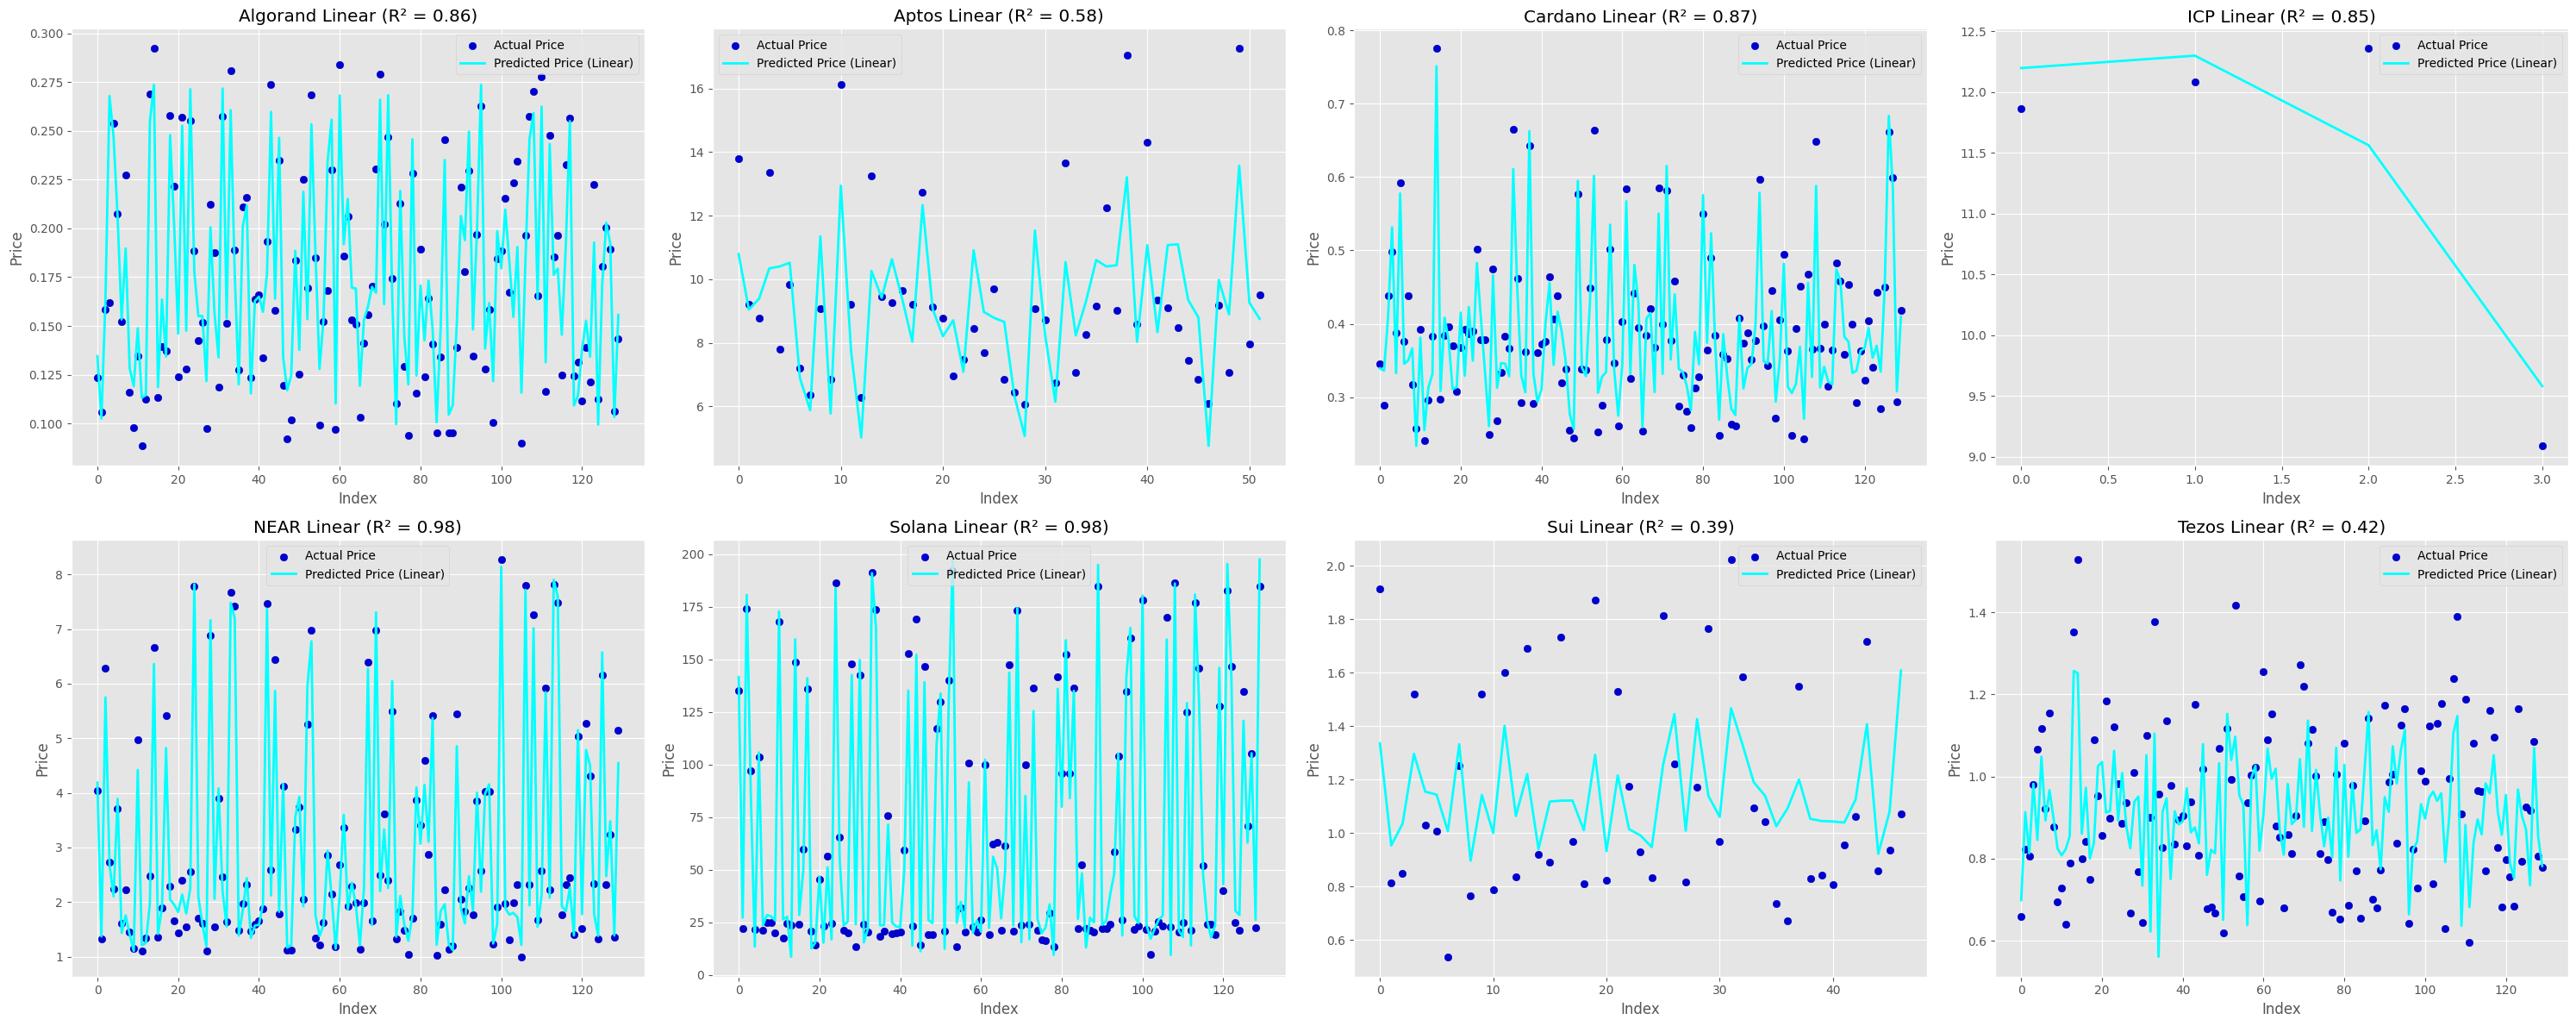

Equation for Algorand: Equation for Algorand (Linear): y = 1.69e-01 + 3.81e-02 * x_1 + -2.14e-02 * x_2 + 2.25e-03 * x_3 + 1.47e-03 * x_4 + -2.92e-02 * x_5
Equation for Aptos: Equation for Aptos (Linear): y = 8.98e+00 + 3.71e+00 * x_1 + -4.86e+00 * x_2 + 7.26e-04 * x_3 + 1.13e-01 * x_4 + 0.00e+00 * x_5
Equation for Cardano: Equation for Cardano (Linear): y = 4.00e-01 + 1.57e-01 * x_1 + -1.68e-02 * x_2 + -3.36e-03 * x_3 + 2.41e-03 * x_4 + -5.39e-02 * x_5
Equation for ICP: Equation for ICP (Linear): y = 1.09e+01 + 5.51e-01 * x_1 + -3.93e-01 * x_2 + -1.30e-01 * x_3 + -1.38e-01 * x_4 + 0.00e+00 * x_5
Equation for NEAR: Equation for NEAR (Linear): y = 3.13e+00 + 2.20e+00 * x_1 + -4.16e-01 * x_2 + 2.03e-01 * x_3 + 6.71e-02 * x_4 + 5.51e-02 * x_5
Equation for Solana: Equation for Solana (Linear): y = 7.40e+01 + 7.65e+01 * x_1 + -1.84e+01 * x_2 + 1.95e+00 * x_3 + 2.27e+00 * x_4 + -5.40e-01 * x_5
Equation for Sui: Equation for Sui (Linear): y = 1.18e+00 + 4.54e-02 * x_1 + 5.54e-02 * x_2 + 2.16e-

In [44]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(30, 12))
axes = axes.flatten()

equations = []
scalers = {}
for i, token in enumerate(chain_names):
    # Extract features and target
    df = datasets[token]
    df = df[df['StablesMCap'].notna()]
    df = df[df['StakingRewards'].notna()]

    

    X = df[['TVL', 'StablesMCap', 'StakingRewards', 'Liquidity', 'InterestRate']]
    y = df['price']

    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)

    scalers[token] = scaler

    # Fit linear regression model
    linear_model = fit_linear_model(X_train, y_train)
    y_pred_linear = linear_model.predict(scaler.transform(X_test))
    r2_linear = r2_score(y_test, y_pred_linear)
    
    # Get the coefficients and intercept in scientific notation for linear model
    coeffs = linear_model.coef_
    intercept = linear_model.intercept_
    equation_linear = f'y = {intercept:.2e}'
    for j, coef in enumerate(coeffs):
        equation_linear += f' + {coef:.2e} * x_{j+1}'
    
    # Store equation for linear model
    equations.append(f'Equation for {token} (Linear): {equation_linear}')



    # Plot linear regression
    plot_regression_line(axes[i], X_test, y_test, y_pred_linear, 
                         f'{token} Linear (R² = {r2_linear:.2f})', label='Linear')

plt.tight_layout()
plt.show()

for token, equation in zip(chain_names, equations):
    print(f'Equation for {token}: {equation}')

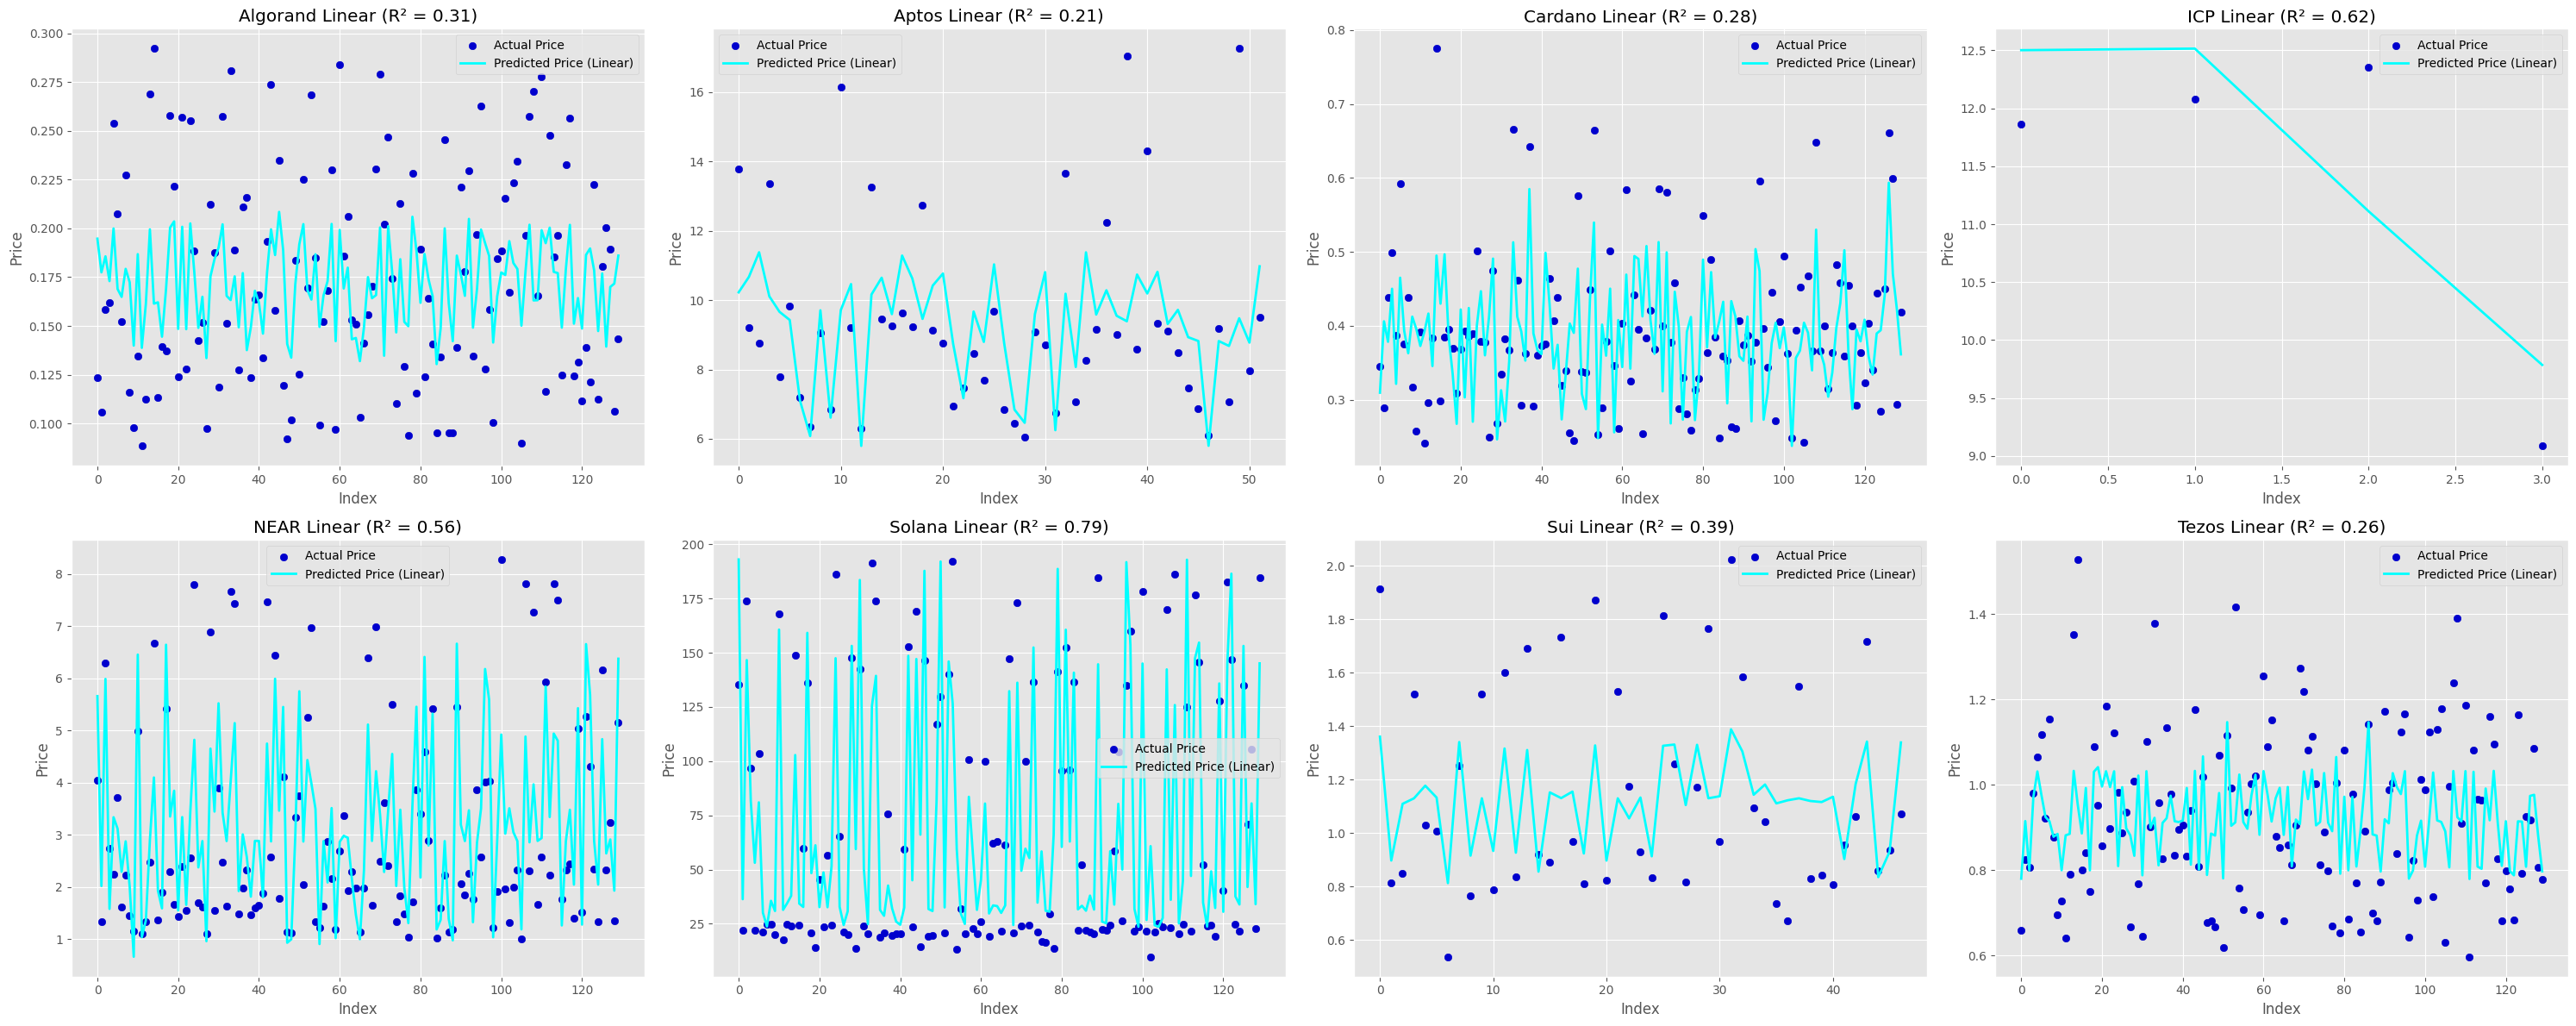

Equation for Algorand: Equation for Algorand (Linear): y = 1.69e-01 + 2.74e-02 * x_1 + -2.47e-02 * x_2
Equation for Aptos: Equation for Aptos (Linear): y = 8.98e+00 + -1.54e+00 * x_1 + 9.65e-03 * x_2
Equation for Cardano: Equation for Cardano (Linear): y = 4.00e-01 + 9.57e-02 * x_1 + 3.79e-02 * x_2
Equation for ICP: Equation for ICP (Linear): y = 1.09e+01 + -8.09e-01 * x_1 + 5.63e-02 * x_2
Equation for NEAR: Equation for NEAR (Linear): y = 3.13e+00 + 1.04e+00 * x_1 + 8.14e-01 * x_2
Equation for Solana: Equation for Solana (Linear): y = 7.40e+01 + 5.11e+01 * x_1 + 6.22e+00 * x_2
Equation for Sui: Equation for Sui (Linear): y = 1.18e+00 + 6.86e-02 * x_1 + 2.61e-01 * x_2
Equation for Tezos: Equation for Tezos (Linear): y = 9.15e-01 + 7.94e-02 * x_1 + -3.47e-03 * x_2


In [45]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(30, 12))
axes = axes.flatten()

equations = []
scalers_2 = {}
for i, token in enumerate(chain_names):
    # Extract features and target
    df = datasets[token]
    df = df[df['StablesMCap'].notna()]
    df = df[df['StakingRewards'].notna()]

    

    X = df[['StablesMCap', 'StakingRewards']]
    y = df['price']

    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    scalers_2[token] = scaler

    # Fit linear regression model
    linear_model = fit_linear_model(X_train, y_train)
    y_pred_linear = linear_model.predict(scaler.transform(X_test))
    r2_linear = r2_score(y_test, y_pred_linear)
    
    # Get the coefficients and intercept in scientific notation for linear model
    coeffs = linear_model.coef_
    intercept = linear_model.intercept_
    equation_linear = f'y = {intercept:.2e}'
    for j, coef in enumerate(coeffs):
        equation_linear += f' + {coef:.2e} * x_{j+1}'
    
    # Store equation for linear model
    equations.append(f'Equation for {token} (Linear): {equation_linear}')



    # Plot linear regression
    plot_regression_line(axes[i], X_test, y_test, y_pred_linear, 
                         f'{token} Linear (R² = {r2_linear:.2f})', label='Linear')

plt.tight_layout()
plt.show()

for token, equation in zip(chain_names, equations):
    print(f'Equation for {token}: {equation}')

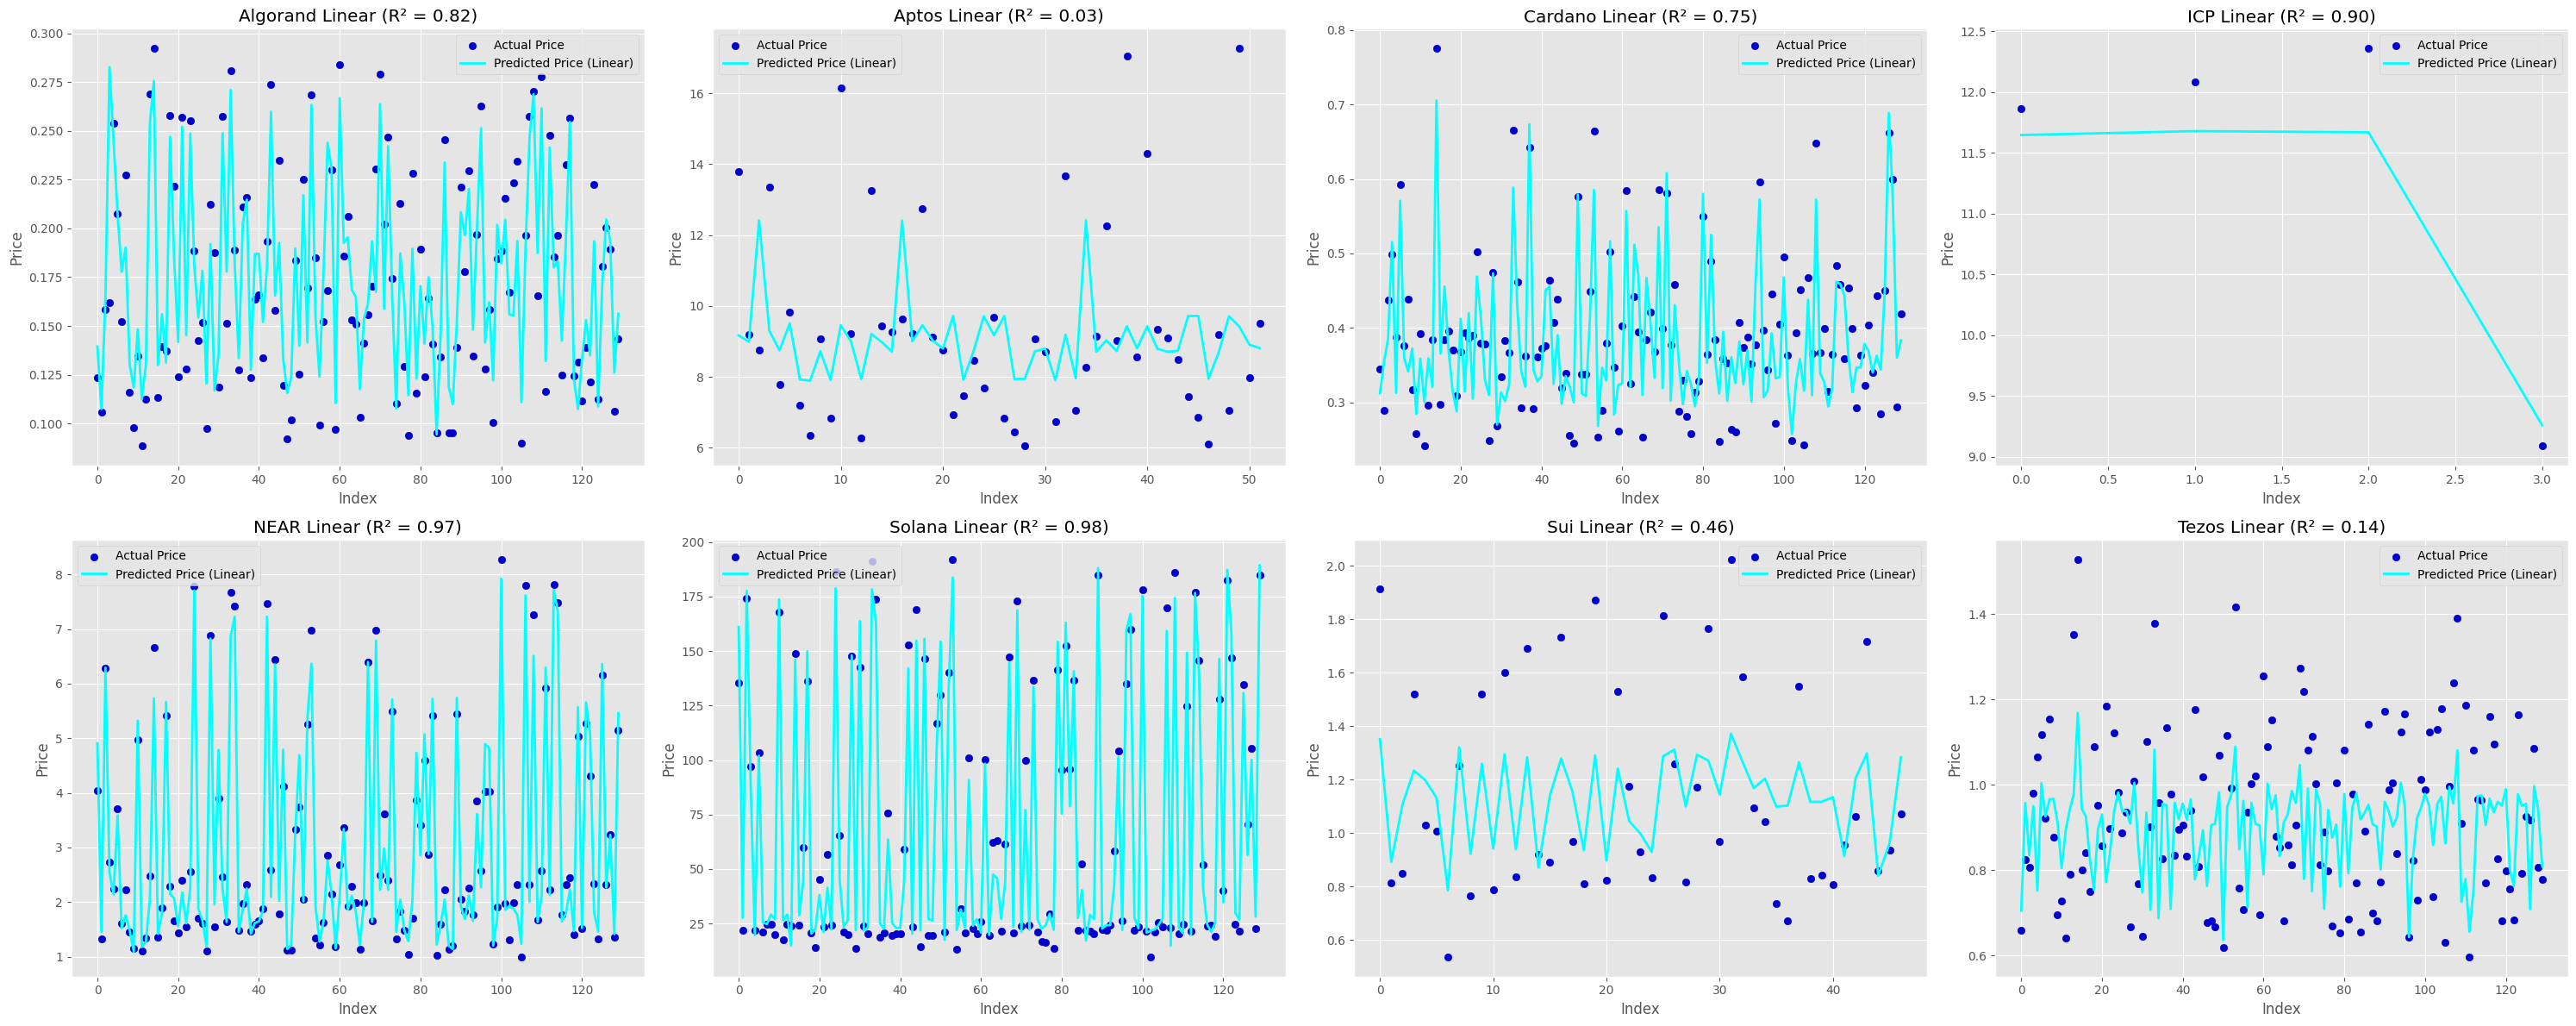

Equation for Algorand: Equation for Algorand (Linear): y = 1.69e-01 + 4.35e-02 * x_1 + 2.65e-03 * x_2
Equation for Aptos: Equation for Aptos (Linear): y = 8.98e+00 + -9.52e-02 * x_1 + 9.21e-01 * x_2
Equation for Cardano: Equation for Cardano (Linear): y = 4.00e-01 + 1.24e-01 * x_1 + 3.51e-02 * x_2
Equation for ICP: Equation for ICP (Linear): y = 1.09e+01 + 1.04e+00 * x_1 + -2.62e-01 * x_2
Equation for NEAR: Equation for NEAR (Linear): y = 3.13e+00 + 1.92e+00 * x_1 + 1.96e-01 * x_2
Equation for Solana: Equation for Solana (Linear): y = 7.40e+01 + 5.87e+01 * x_1 + 2.51e+00 * x_2
Equation for Sui: Equation for Sui (Linear): y = 1.18e+00 + 5.29e-02 * x_1 + 2.43e-01 * x_2
Equation for Tezos: Equation for Tezos (Linear): y = 9.15e-01 + 9.16e-02 * x_1 + -6.24e-02 * x_2


In [18]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(30, 12))
axes = axes.flatten()

equations = []
scaler_3 = {}
for i, token in enumerate(chain_names):
    # Extract features and target
    df = datasets[token]
    df = df[df['StablesMCap'].notna()]
    df = df[df['StakingRewards'].notna()]

    

    X = df[['TVL', 'StakingRewards']]
    y = df['price']

    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    scaler_3[token] = scaler

    # Fit linear regression model
    linear_model = fit_linear_model(X_train, y_train)
    y_pred_linear = linear_model.predict(scaler.transform(X_test))
    r2_linear = r2_score(y_test, y_pred_linear)
    
    # Get the coefficients and intercept in scientific notation for linear model
    coeffs = linear_model.coef_
    intercept = linear_model.intercept_
    equation_linear = f'y = {intercept:.2e}'
    for j, coef in enumerate(coeffs):
        equation_linear += f' + {coef:.2e} * x_{j+1}'
    
    # Store equation for linear model
    equations.append(f'Equation for {token} (Linear): {equation_linear}')



    # Plot linear regression
    plot_regression_line(axes[i], X_test, y_test, y_pred_linear, 
                         f'{token} Linear (R² = {r2_linear:.2f})', label='Linear')

plt.tight_layout()
plt.show()

for token, equation in zip(chain_names, equations):
    print(f'Equation for {token}: {equation}')

In [23]:
algo_scaler = scaler_3['Algorand']
algo_scaler.mean_, algo_scaler.var_  

(array([1.63506268e+08, 6.16848337e+00]),
 array([2.90870892e+15, 1.79584807e+00]))

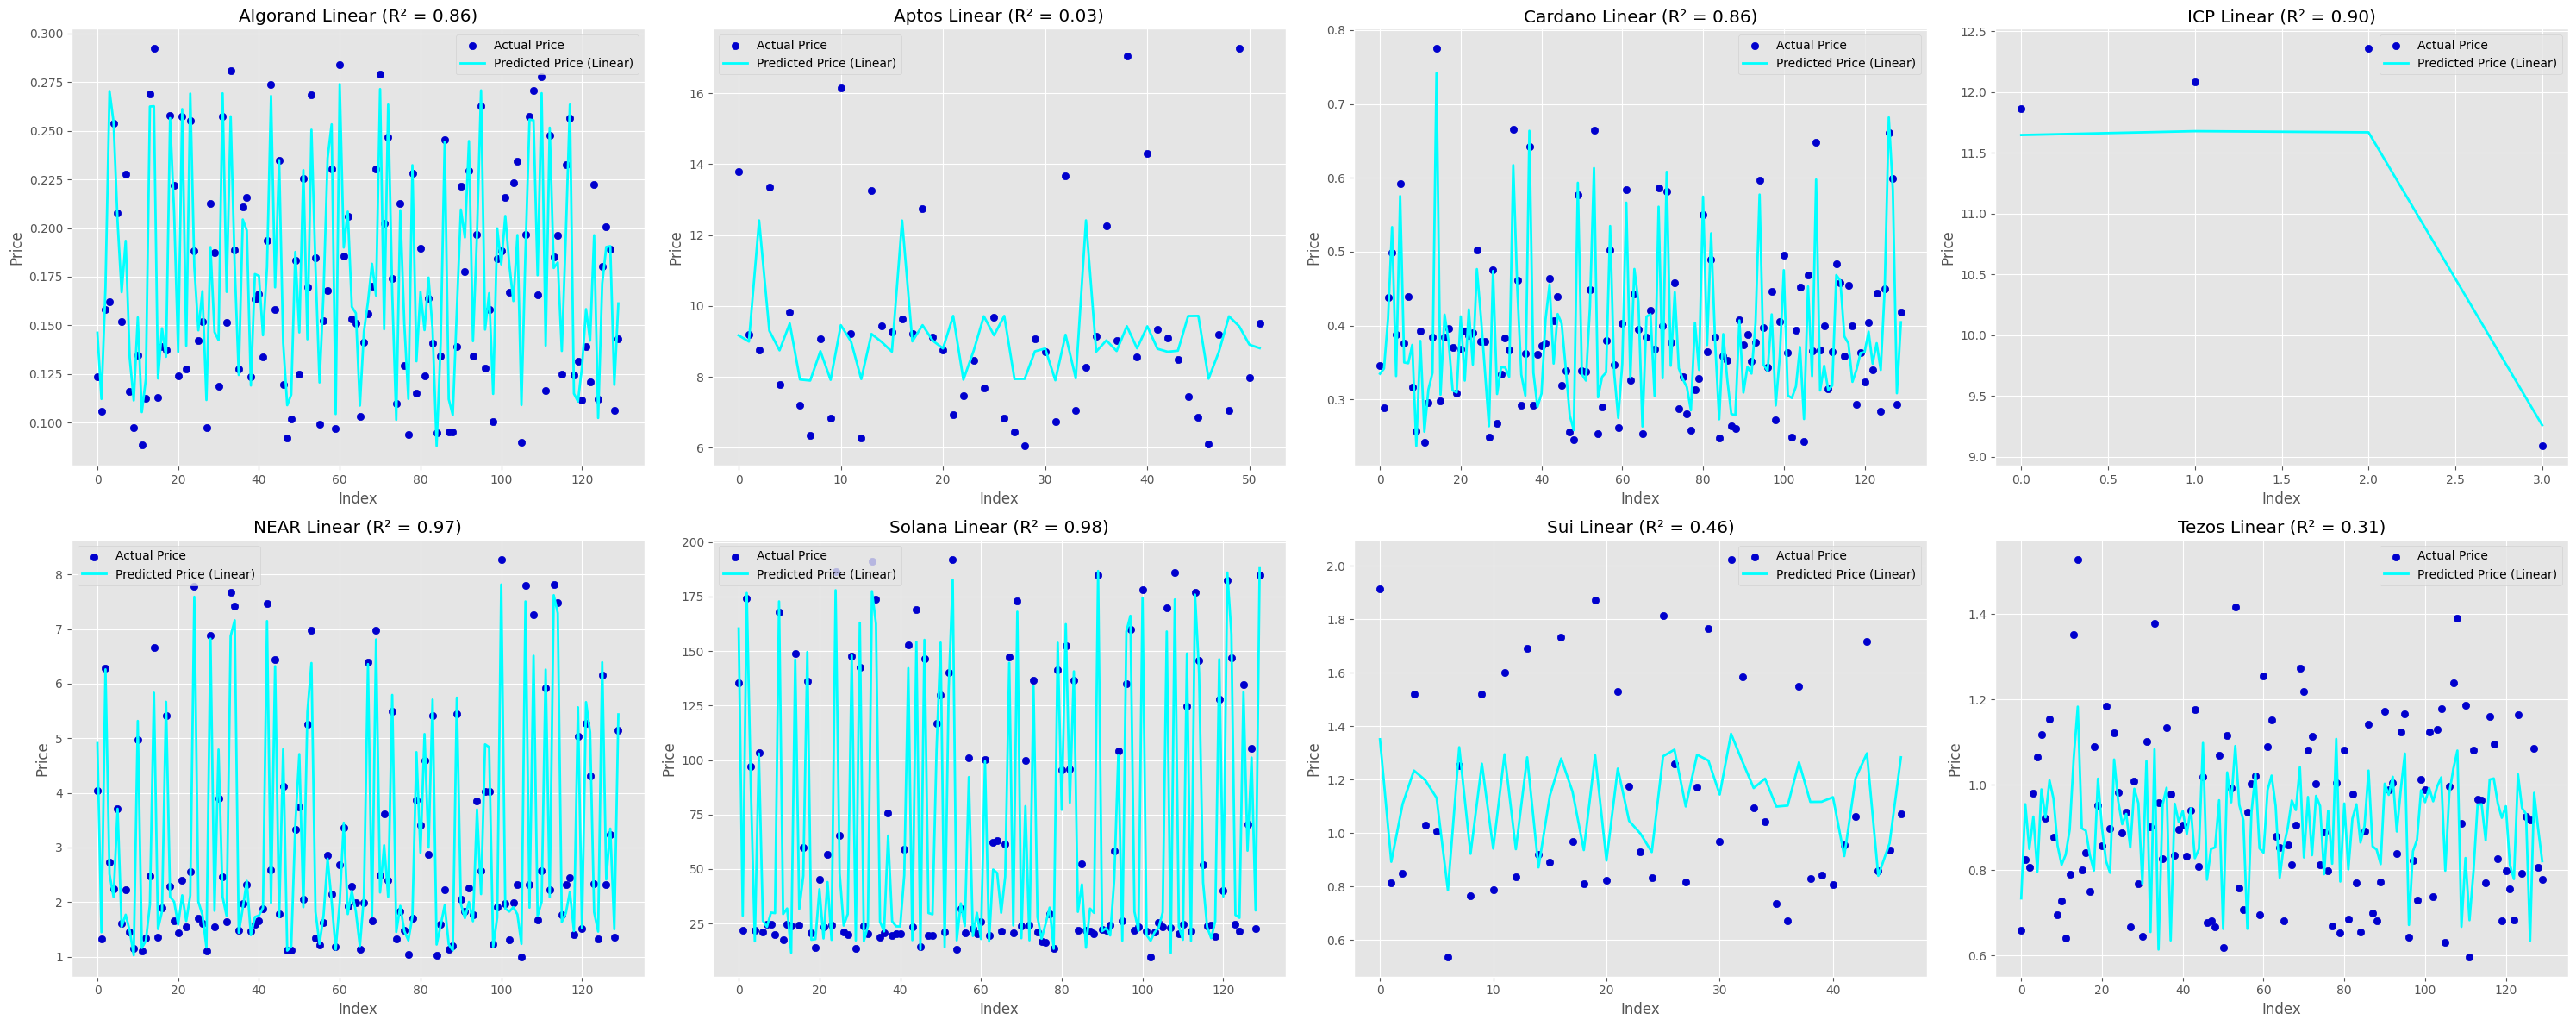

Equation for Algorand: Equation for Algorand (Linear): y = 1.69e-01 + 3.87e-02 * x_1 + -5.45e-03 * x_2 + -1.43e-02 * x_3
Equation for Aptos: Equation for Aptos (Linear): y = 8.98e+00 + -9.52e-02 * x_1 + 9.21e-01 * x_2 + 0.00e+00 * x_3
Equation for Cardano: Equation for Cardano (Linear): y = 4.00e-01 + 1.50e-01 * x_1 + -5.39e-03 * x_2 + -6.58e-02 * x_3
Equation for ICP: Equation for ICP (Linear): y = 1.09e+01 + 1.04e+00 * x_1 + -2.62e-01 * x_2 + 0.00e+00 * x_3
Equation for NEAR: Equation for NEAR (Linear): y = 3.13e+00 + 1.82e+00 * x_1 + 2.97e-01 * x_2 + 1.28e-01 * x_3
Equation for Solana: Equation for Solana (Linear): y = 7.40e+01 + 5.72e+01 * x_1 + 2.68e+00 * x_2 + 2.80e+00 * x_3
Equation for Sui: Equation for Sui (Linear): y = 1.18e+00 + 5.29e-02 * x_1 + 2.43e-01 * x_2 + 0.00e+00 * x_3
Equation for Tezos: Equation for Tezos (Linear): y = 9.15e-01 + 1.08e-01 * x_1 + -4.44e-02 * x_2 + -6.06e-02 * x_3


In [47]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(30, 12))
axes = axes.flatten()

equations = []
scaler_4 = {}
for i, token in enumerate(chain_names):
    # Extract features and target
    df = datasets[token]
    df = df[df['StablesMCap'].notna()]
    df = df[df['StakingRewards'].notna()]

    

    X = df[['TVL', 'StakingRewards', 'InterestRate']]
    y = df['price']

    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    scaler_4[token] = scaler

    # Fit linear regression model
    linear_model = fit_linear_model(X_train, y_train)
    y_pred_linear = linear_model.predict(scaler.transform(X_test))
    r2_linear = r2_score(y_test, y_pred_linear)
    
    # Get the coefficients and intercept in scientific notation for linear model
    coeffs = linear_model.coef_
    intercept = linear_model.intercept_
    equation_linear = f'y = {intercept:.2e}'
    for j, coef in enumerate(coeffs):
        equation_linear += f' + {coef:.2e} * x_{j+1}'
    
    # Store equation for linear model
    equations.append(f'Equation for {token} (Linear): {equation_linear}')



    # Plot linear regression
    plot_regression_line(axes[i], X_test, y_test, y_pred_linear, 
                         f'{token} Linear (R² = {r2_linear:.2f})', label='Linear')

plt.tight_layout()
plt.show()

for token, equation in zip(chain_names, equations):
    print(f'Equation for {token}: {equation}')

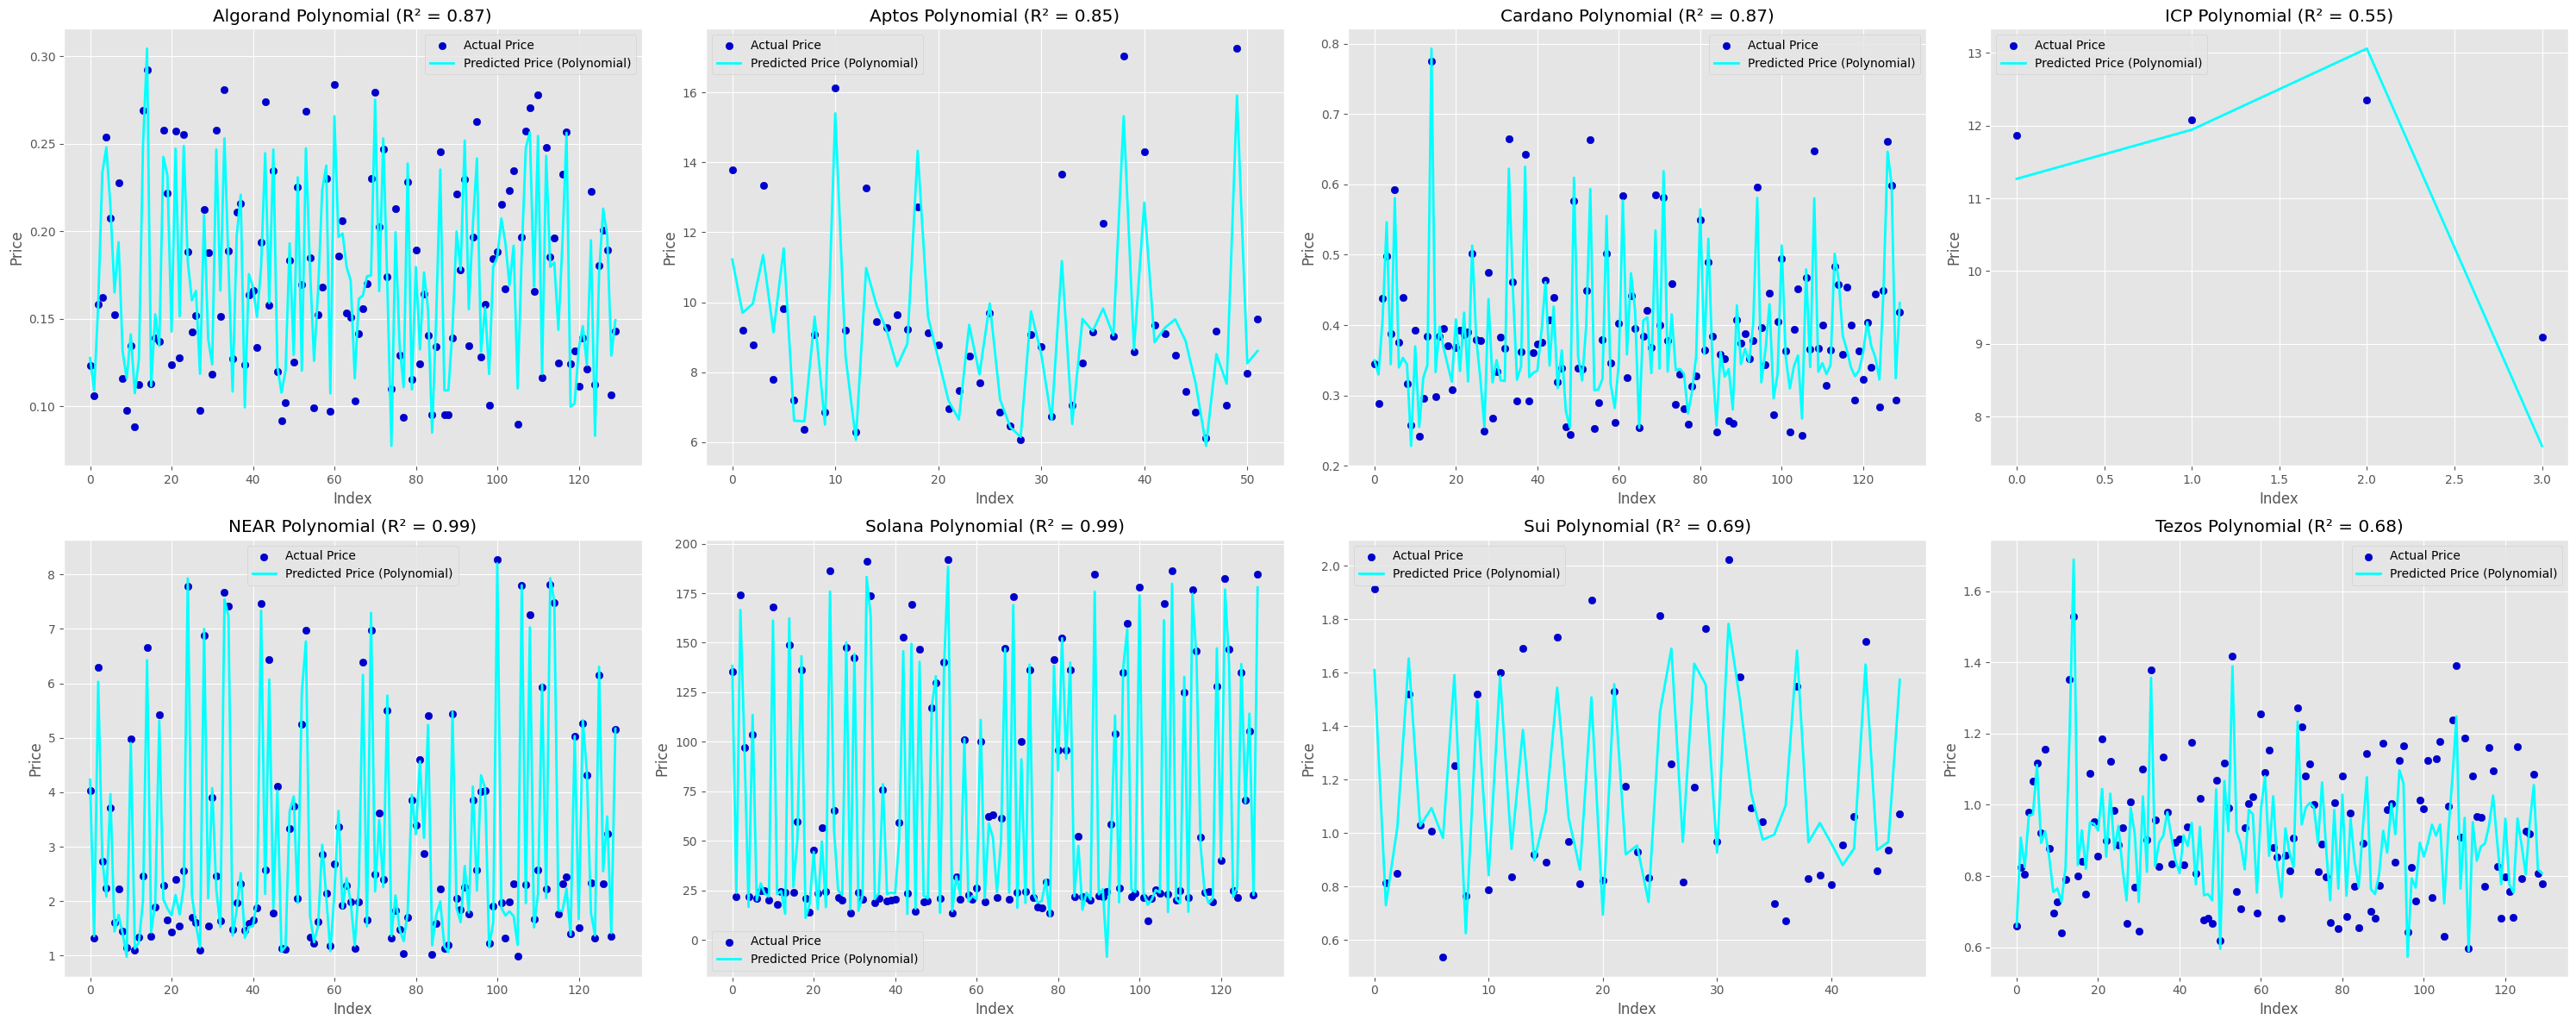

Equation for Algorand: Equation for Algorand (Polynomial): y = 1.68e-01 + 3.97e-02 * x_1 + 1.02e-03 * x_2 + -4.74e-03 * x_3 + 8.56e-04 * x_4 + -6.04e-03 * x_5 + -3.43e-03 * x_6 + -2.90e-03 * x_7 + 5.29e-03 * x_8 + 1.65e-02 * x_9 + -3.63e-03 * x_10 + 1.08e-03 * x_11 + -8.24e-03 * x_12 + -1.91e-03 * x_13 + -4.76e-04 * x_14
Equation for Aptos: Equation for Aptos (Polynomial): y = 8.17e+00 + 4.21e+00 * x_1 + -6.64e+00 * x_2 + 7.88e-01 * x_3 + 5.94e-02 * x_4 + -5.61e-01 * x_5 + 2.19e+00 * x_6 + 4.78e+00 * x_7 + 6.25e-01 * x_8 + -1.58e+00 * x_9 + -7.39e+00 * x_10 + -5.28e-01 * x_11 + -9.14e-01 * x_12 + 2.05e-02 * x_13 + -3.29e-02 * x_14
Equation for Cardano: Equation for Cardano (Polynomial): y = 3.90e-01 + 1.51e-01 * x_1 + -5.48e-02 * x_2 + 6.80e-03 * x_3 + 6.04e-03 * x_4 + -5.80e-03 * x_5 + 3.32e-02 * x_6 + -6.75e-02 * x_7 + 6.08e-03 * x_8 + -1.75e-02 * x_9 + 4.42e-02 * x_10 + -6.63e-03 * x_11 + 6.78e-04 * x_12 + -3.96e-05 * x_13 + -6.04e-04 * x_14
Equation for ICP: Equation for ICP (Polyn

In [24]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(30, 12))
axes = axes.flatten()

equations_poly = []
scaler_poly = {}
for i, token in enumerate(chain_names):
    # Extract features and target
    df = datasets[token]
    
    df = df[df['StablesMCap'].notna()]
    df = df[df['StakingRewards'].notna()]

    
    X = df[['TVL', 'StablesMCap', 'StakingRewards', 'Liquidity']]
    y = df['price']

    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    scaler_poly[token] = scaler

    # Fit polynomial regression model
    poly_model, poly = fit_polynomial_model(X_train, y_train, degree=2)
    X_poly_test = poly.transform(scaler.transform(X_test))
    y_pred_poly = poly_model.predict(X_poly_test)
    r2_poly = r2_score(y_test, y_pred_poly)
    
    # Get the coefficients and intercept in scientific notation for polynomial model
    coeffs = poly_model.coef_
    intercept = poly_model.intercept_
    equation_poly = f'y = {intercept:.2e}'
    for j, coef in enumerate(coeffs):
        equation_poly += f' + {coef:.2e} * x_{j+1}'

    # Store equation for linear model
    equations_poly.append(f'Equation for {token} (Polynomial): {equation_poly}')


    # Plot polynomial regression
    plot_regression_line(axes[i], X_test, y_test, y_pred_poly, 
                            f'{token} Polynomial (R² = {r2_poly:.2f})', label='Polynomial')

plt.tight_layout()
plt.show()

for token, equation in zip(chain_names, equations_poly):
    print(f'Equation for {token}: {equation}')


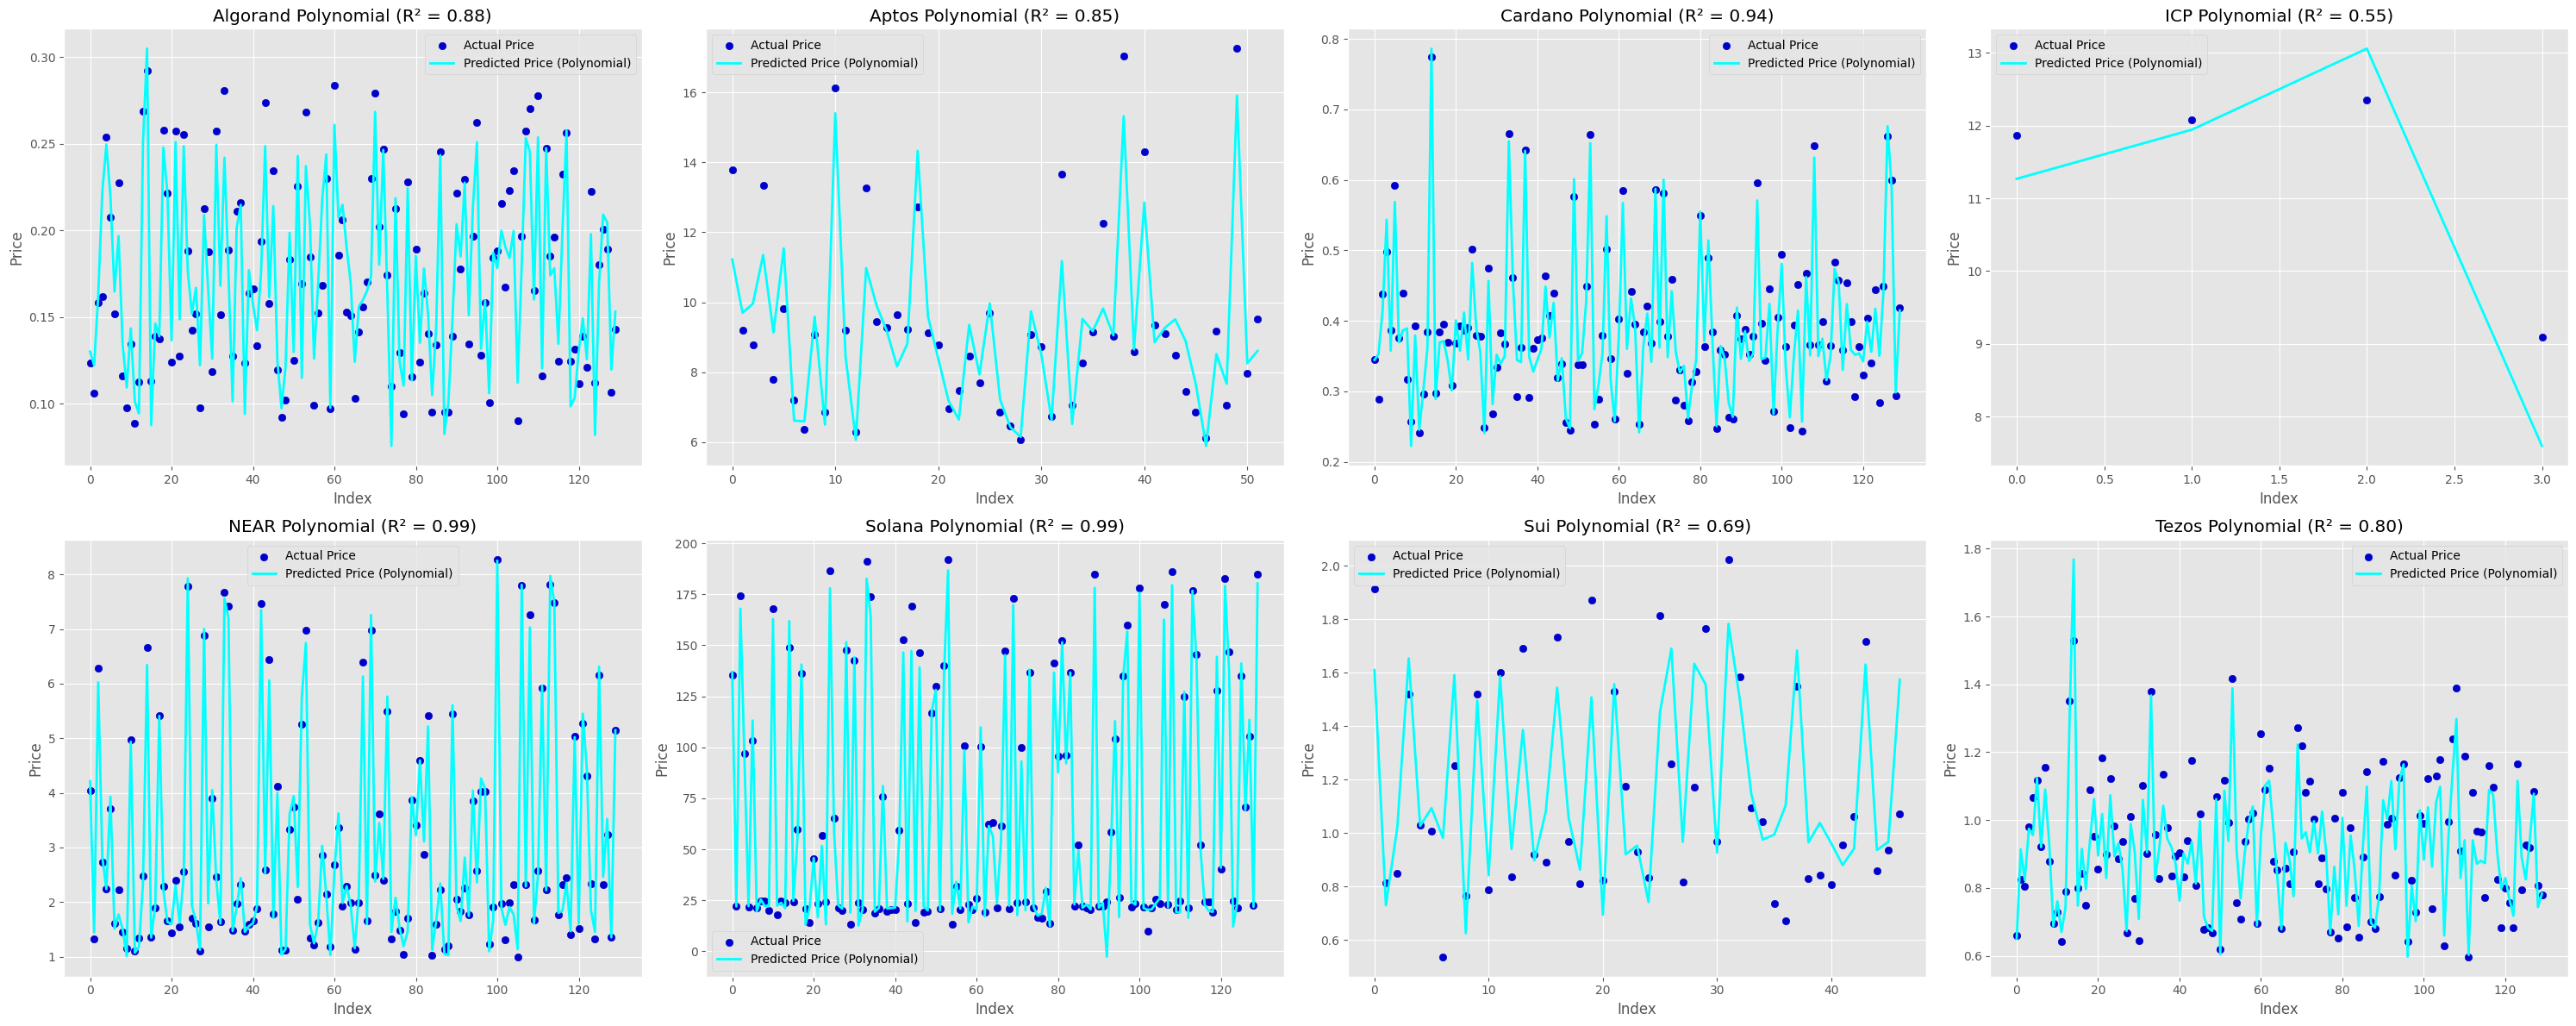

Equation for Algorand: Equation for Algorand (Polynomial): y = 1.69e-01 + 3.31e-02 * x_1 + -4.77e-02 * x_2 + -7.27e-03 * x_3 + -2.91e-03 * x_4 + -7.70e-02 * x_5 + -6.20e-03 * x_6 + -4.87e-03 * x_7 + -5.95e-03 * x_8 + 5.60e-03 * x_9 + -5.79e-03 * x_10 + 1.14e-01 * x_11 + -5.37e-02 * x_12 + 9.29e-03 * x_13 + 1.42e-01 * x_14 + -2.88e-04 * x_15 + -3.54e-03 * x_16 + -4.58e-02 * x_17 + -7.17e-05 * x_18 + 9.62e-03 * x_19 + 3.01e-02 * x_20
Equation for Aptos: Equation for Aptos (Polynomial): y = 8.17e+00 + 4.21e+00 * x_1 + -6.64e+00 * x_2 + 7.88e-01 * x_3 + 5.94e-02 * x_4 + -1.33e-14 * x_5 + -5.61e-01 * x_6 + 2.19e+00 * x_7 + 4.78e+00 * x_8 + 6.25e-01 * x_9 + 4.44e-15 * x_10 + -1.58e+00 * x_11 + -7.39e+00 * x_12 + -5.28e-01 * x_13 + 1.55e-15 * x_14 + -9.14e-01 * x_15 + 2.05e-02 * x_16 + 0.00e+00 * x_17 + -3.29e-02 * x_18 + 0.00e+00 * x_19 + 0.00e+00 * x_20
Equation for Cardano: Equation for Cardano (Polynomial): y = 4.25e-01 + 1.95e-01 * x_1 + -2.95e-02 * x_2 + -1.57e-02 * x_3 + -1.39e-04 * x_

In [48]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(30, 12))
axes = axes.flatten()

equations_poly = []
scaler_poly = {}
for i, token in enumerate(chain_names):
    # Extract features and target
    df = datasets[token]
    
    df = df[df['StablesMCap'].notna()]
    df = df[df['StakingRewards'].notna()]

    
    X = df[['TVL', 'StablesMCap', 'StakingRewards', 'Liquidity', 'InterestRate']]
    y = df['price']

    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    scaler_poly[token] = scaler

    # Fit polynomial regression model
    poly_model, poly = fit_polynomial_model(X_train, y_train, degree=2)
    X_poly_test = poly.transform(scaler.transform(X_test))
    y_pred_poly = poly_model.predict(X_poly_test)
    r2_poly = r2_score(y_test, y_pred_poly)
    
    # Get the coefficients and intercept in scientific notation for polynomial model
    coeffs = poly_model.coef_
    intercept = poly_model.intercept_
    equation_poly = f'y = {intercept:.2e}'
    for j, coef in enumerate(coeffs):
        equation_poly += f' + {coef:.2e} * x_{j+1}'

    # Store equation for linear model
    equations_poly.append(f'Equation for {token} (Polynomial): {equation_poly}')


    # Plot polynomial regression
    plot_regression_line(axes[i], X_test, y_test, y_pred_poly, 
                            f'{token} Polynomial (R² = {r2_poly:.2f})', label='Polynomial')

plt.tight_layout()
plt.show()

for token, equation in zip(chain_names, equations_poly):
    print(f'Equation for {token}: {equation}')


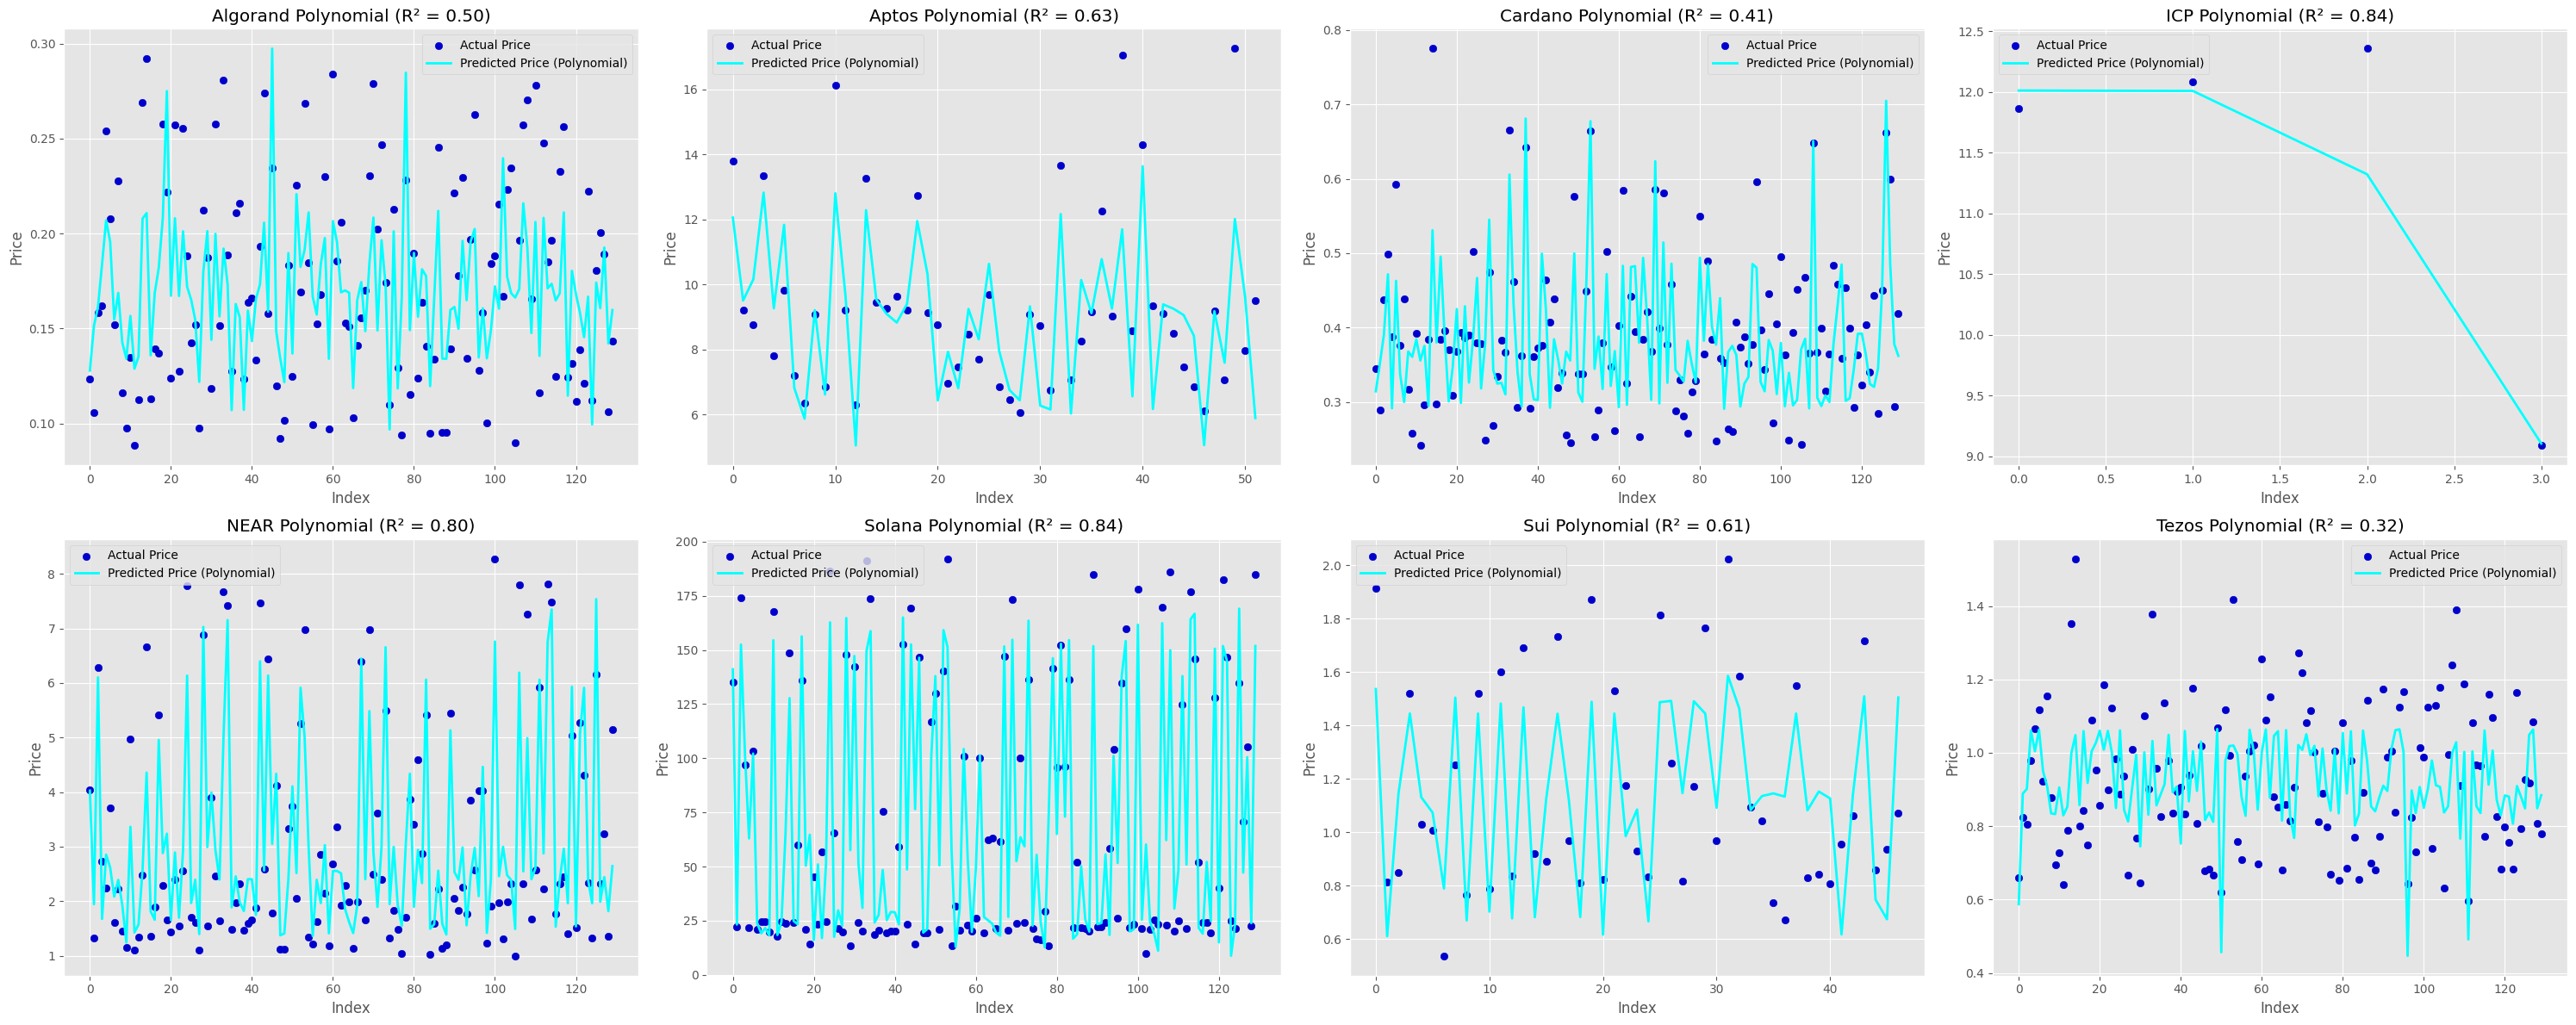

Equation for Algorand: Equation for Algorand (Polynomial): y = 1.43e-01 + -1.05e-02 * x_1 + -1.10e-02 * x_2 + 2.66e-02 * x_3 + 3.67e-02 * x_4 + -2.81e-02 * x_5
Equation for Aptos: Equation for Aptos (Polynomial): y = 1.01e+01 + -2.72e+00 * x_1 + 2.04e+00 * x_2 + -1.87e+00 * x_3 + -6.96e+00 * x_4 + -3.58e+00 * x_5
Equation for Cardano: Equation for Cardano (Polynomial): y = 3.51e-01 + 1.18e-01 * x_1 + 7.47e-03 * x_2 + 4.40e-02 * x_3 + -3.20e-03 * x_4 + 2.47e-03 * x_5
Equation for ICP: Equation for ICP (Polynomial): y = 1.11e+01 + -7.64e-01 * x_1 + 2.27e-01 * x_2 + -3.56e-01 * x_3 + -6.95e-01 * x_4 + -2.47e-01 * x_5
Equation for NEAR: Equation for NEAR (Polynomial): y = 3.47e+00 + 1.82e+00 * x_1 + 1.44e+00 * x_2 + -9.17e-01 * x_3 + 1.91e+00 * x_4 + -3.30e-02 * x_5
Equation for Solana: Equation for Solana (Polynomial): y = 9.33e+01 + 7.36e+01 * x_1 + 1.91e+00 * x_2 + -2.14e+01 * x_3 + 8.41e+00 * x_4 + 1.74e-01 * x_5
Equation for Sui: Equation for Sui (Polynomial): y = 1.26e+00 + 1.31e-02 

In [49]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(30, 12))
axes = axes.flatten()

equations_poly = []
scaler_poly2 = {}
for i, token in enumerate(chain_names):
    # Extract features and target
    df = datasets[token]
    
    df = df[df['StablesMCap'].notna()]
    df = df[df['StakingRewards'].notna()]

    
    X = df[['StablesMCap', 'StakingRewards']]
    y = df['price']

    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    scaler_poly2[token] = scaler

    # Fit polynomial regression model
    poly_model, poly = fit_polynomial_model(X_train, y_train, degree=2)
    X_poly_test = poly.transform(scaler.transform(X_test))
    y_pred_poly = poly_model.predict(X_poly_test)
    r2_poly = r2_score(y_test, y_pred_poly)
    
    # Get the coefficients and intercept in scientific notation for polynomial model
    coeffs = poly_model.coef_
    intercept = poly_model.intercept_
    equation_poly = f'y = {intercept:.2e}'
    for j, coef in enumerate(coeffs):
        equation_poly += f' + {coef:.2e} * x_{j+1}'

    # Store equation for linear model
    equations_poly.append(f'Equation for {token} (Polynomial): {equation_poly}')


    # Plot polynomial regression
    plot_regression_line(axes[i], X_test, y_test, y_pred_poly, 
                            f'{token} Polynomial (R² = {r2_poly:.2f})', label='Polynomial')

plt.tight_layout()
plt.show()

for token, equation in zip(chain_names, equations_poly):
    print(f'Equation for {token}: {equation}')


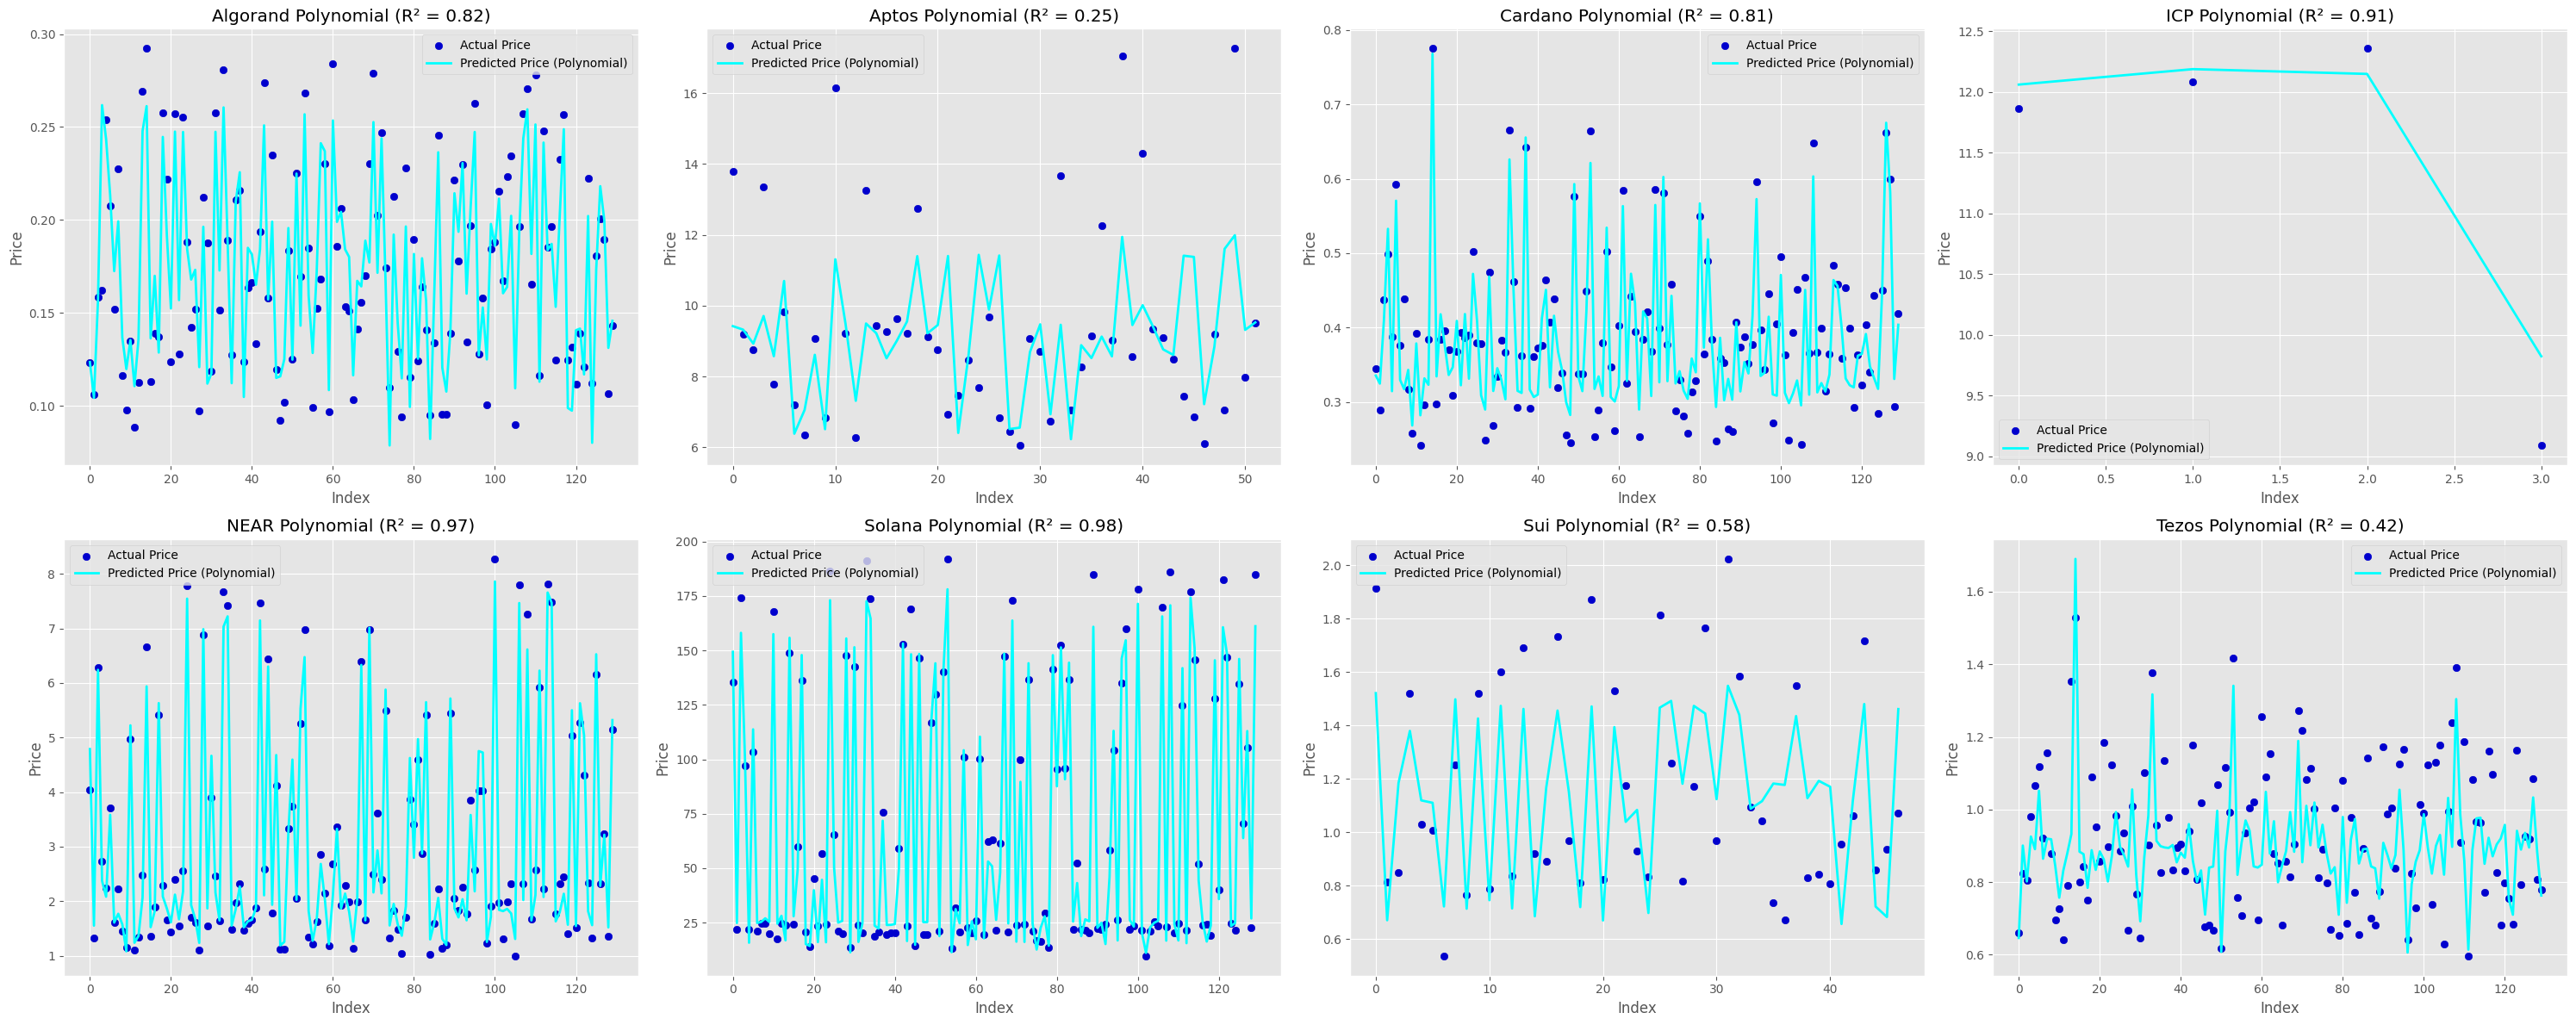

Equation for Algorand: Equation for Algorand (Polynomial): y = 1.84e-01 + 4.76e-02 * x_1 + 2.66e-03 * x_2 + -6.43e-03 * x_3 + -3.76e-03 * x_4 + -9.92e-03 * x_5
Equation for Aptos: Equation for Aptos (Polynomial): y = 9.33e+00 + 5.68e-01 * x_1 + 2.55e+00 * x_2 + 4.85e-01 * x_3 + 9.79e-01 * x_4 + -2.79e-01 * x_5
Equation for Cardano: Equation for Cardano (Polynomial): y = 3.69e-01 + 1.20e-01 * x_1 + 1.27e-02 * x_2 + 1.31e-02 * x_3 + -2.05e-02 * x_4 + 8.18e-03 * x_5
Equation for ICP: Equation for ICP (Polynomial): y = 3.44e+00 + -3.36e+00 * x_1 + 1.21e+01 * x_2 + 8.81e-01 * x_3 + 1.11e+01 * x_4 + -2.54e+00 * x_5
Equation for NEAR: Equation for NEAR (Polynomial): y = 3.09e+00 + 1.79e+00 * x_1 + 2.89e-01 * x_2 + -1.98e-02 * x_3 + 2.48e-01 * x_4 + -6.46e-02 * x_5
Equation for Solana: Equation for Solana (Polynomial): y = 8.46e+01 + 6.48e+01 * x_1 + 5.38e+00 * x_2 + -1.21e+01 * x_3 + 7.41e+00 * x_4 + -4.53e-01 * x_5
Equation for Sui: Equation for Sui (Polynomial): y = 1.29e+00 + 1.50e-02 * x_

In [50]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(30, 12))
axes = axes.flatten()

equations_poly = []
scaler_poly3 = {}
for i, token in enumerate(chain_names):
    # Extract features and target
    df = datasets[token]
    
    df = df[df['StablesMCap'].notna()]
    df = df[df['StakingRewards'].notna()]

    
    X = df[['TVL', 'StakingRewards']]
    y = df['price']

    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    scaler_poly3[token] = scaler

    # Fit polynomial regression model
    poly_model, poly = fit_polynomial_model(X_train, y_train, degree=2)
    X_poly_test = poly.transform(scaler.transform(X_test))
    y_pred_poly = poly_model.predict(X_poly_test)
    r2_poly = r2_score(y_test, y_pred_poly)
    
    # Get the coefficients and intercept in scientific notation for polynomial model
    coeffs = poly_model.coef_
    intercept = poly_model.intercept_
    equation_poly = f'y = {intercept:.2e}'
    for j, coef in enumerate(coeffs):
        equation_poly += f' + {coef:.2e} * x_{j+1}'

    # Store equation for linear model
    equations_poly.append(f'Equation for {token} (Polynomial): {equation_poly}')


    # Plot polynomial regression
    plot_regression_line(axes[i], X_test, y_test, y_pred_poly, 
                            f'{token} Polynomial (R² = {r2_poly:.2f})', label='Polynomial')

plt.tight_layout()
plt.show()

for token, equation in zip(chain_names, equations_poly):
    print(f'Equation for {token}: {equation}')


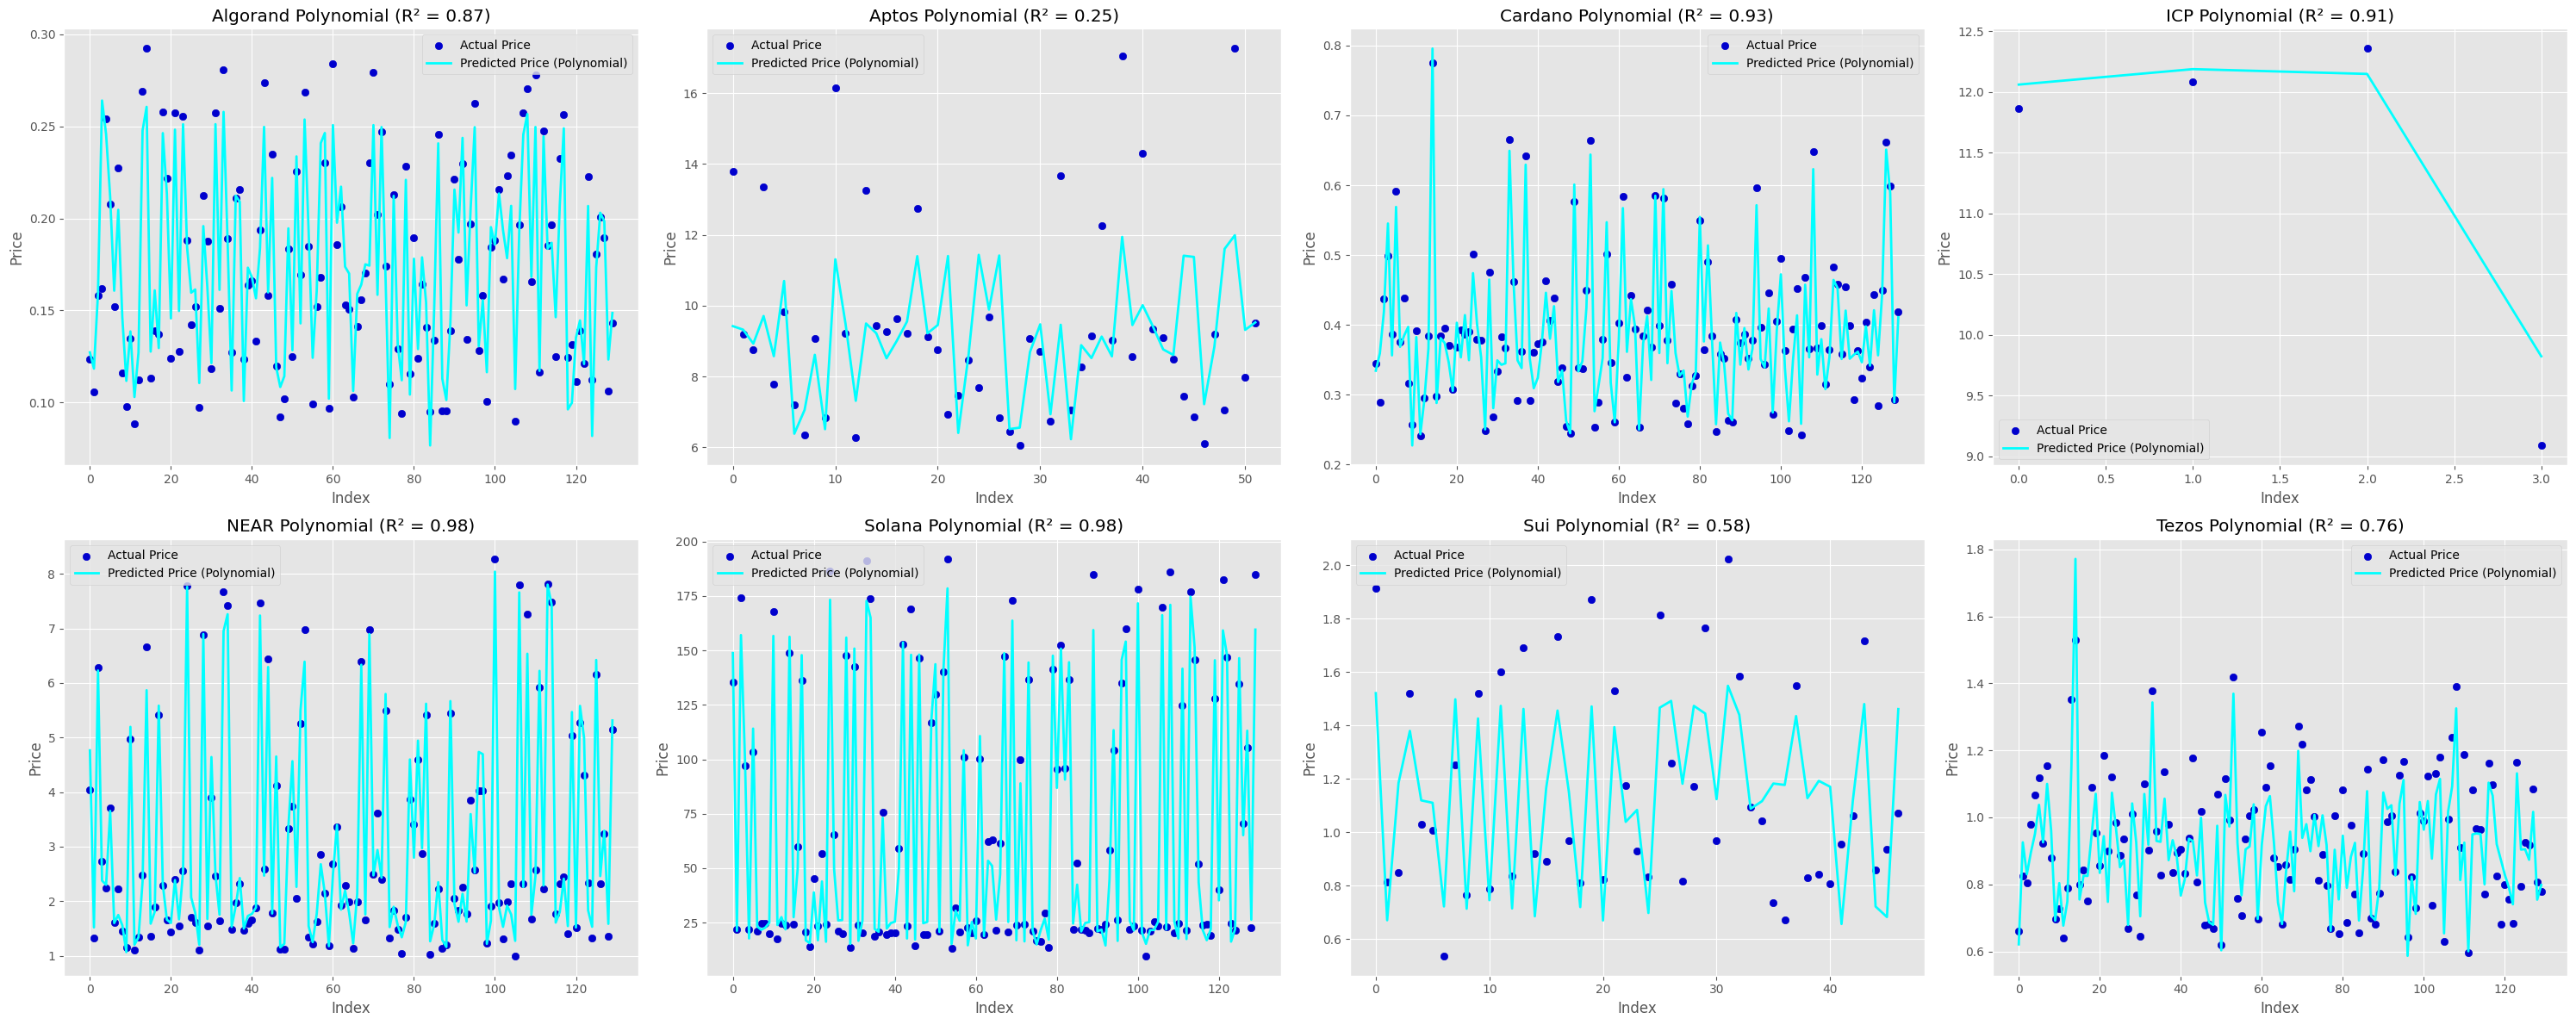

Equation for Algorand: Equation for Algorand (Polynomial): y = 1.87e-01 + 4.10e-02 * x_1 + -6.15e-03 * x_2 + -1.93e-02 * x_3 + -5.30e-03 * x_4 + -5.45e-03 * x_5 + 4.28e-03 * x_6 + -1.13e-02 * x_7 + -2.22e-03 * x_8 + -2.76e-03 * x_9
Equation for Aptos: Equation for Aptos (Polynomial): y = 9.33e+00 + 5.68e-01 * x_1 + 2.55e+00 * x_2 + 0.00e+00 * x_3 + 4.85e-01 * x_4 + 9.79e-01 * x_5 + 0.00e+00 * x_6 + -2.79e-01 * x_7 + 0.00e+00 * x_8 + 0.00e+00 * x_9
Equation for Cardano: Equation for Cardano (Polynomial): y = 4.23e-01 + 1.81e-01 * x_1 + -1.78e-02 * x_2 + -1.44e-01 * x_3 + 1.42e-02 * x_4 + -3.14e-02 * x_5 + -7.32e-02 * x_6 + 6.43e-03 * x_7 + 5.13e-03 * x_8 + -3.97e-03 * x_9
Equation for ICP: Equation for ICP (Polynomial): y = 3.44e+00 + -3.36e+00 * x_1 + 1.21e+01 * x_2 + -3.55e-15 * x_3 + 8.81e-01 * x_4 + 1.11e+01 * x_5 + 4.49e-14 * x_6 + -2.54e+00 * x_7 + 1.07e-14 * x_8 + 0.00e+00 * x_9
Equation for NEAR: Equation for NEAR (Polynomial): y = 3.66e+00 + 2.52e+00 * x_1 + 2.64e-01 * x_2 + -9

In [51]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(30, 12))
axes = axes.flatten()

equations_poly = []
scaler_poly3 = {}
for i, token in enumerate(chain_names):
    # Extract features and target
    df = datasets[token]
    
    df = df[df['StablesMCap'].notna()]
    df = df[df['StakingRewards'].notna()]

    
    X = df[['TVL', 'StakingRewards', 'InterestRate']]
    y = df['price']

    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    scaler_poly3[token] = scaler

    # Fit polynomial regression model
    poly_model, poly = fit_polynomial_model(X_train, y_train, degree=2)
    X_poly_test = poly.transform(scaler.transform(X_test))
    y_pred_poly = poly_model.predict(X_poly_test)
    r2_poly = r2_score(y_test, y_pred_poly)
    
    # Get the coefficients and intercept in scientific notation for polynomial model
    coeffs = poly_model.coef_
    intercept = poly_model.intercept_
    equation_poly = f'y = {intercept:.2e}'
    for j, coef in enumerate(coeffs):
        equation_poly += f' + {coef:.2e} * x_{j+1}'

    # Store equation for linear model
    equations_poly.append(f'Equation for {token} (Polynomial): {equation_poly}')


    # Plot polynomial regression
    plot_regression_line(axes[i], X_test, y_test, y_pred_poly, 
                            f'{token} Polynomial (R² = {r2_poly:.2f})', label='Polynomial')

plt.tight_layout()
plt.show()

for token, equation in zip(chain_names, equations_poly):
    print(f'Equation for {token}: {equation}')


In [36]:
#EXTRA
dau = pd.read_csv('data/algorand_dau.csv')
dau['Date'] = pd.to_datetime(dau['Date'])



Date           TVL     price    market_cap  total_volume  \
0   2022-12-05  1.952681e+08  0.241424  1.723134e+09  4.228876e+07   
2   2022-12-06  1.925492e+08  0.237454  1.691877e+09  7.997809e+07   
4   2022-12-07  1.902759e+08  0.234740  1.669517e+09  4.845631e+07   
6   2022-12-08  1.838453e+08  0.222186  1.583133e+09  7.667316e+07   
8   2022-12-09  1.844228e+08  0.225350  1.606197e+09  5.591705e+07   
..         ...           ...       ...           ...           ...   
671 2024-09-09  1.328328e+08  0.125050  1.030252e+09  5.561982e+07   
672 2024-09-10  1.348553e+08  0.128067  1.054842e+09  5.139842e+07   
673 2024-09-11  1.349787e+08  0.129305  1.065364e+09  4.291470e+07   
674 2024-09-12  1.347614e+08  0.127042  1.047521e+09  4.568111e+07   
675 2024-09-13  1.371008e+08  0.129947  1.071718e+09  3.771744e+07   

     StablesMCap  StakingRewards  Liquidity  InterestRate  DAU_x  DAU_y  
0    312213478.0        7.363497   2.454177          3.83  68979  68979  
2    315170889.0        7.363655   4.727180          3.83  32706  32706  
4    314657387.0        7.367585   2.902414          3.83  28561  28561  
6    311356401.0        7.367823   4.843130          3.83  35592  35592  
8    312601361.0        7.367929   3.481332          3.83  26723  26723  
..           ...             ...        ...           ...    ...    ...  
671  102192172.0        4.128995   5.398664          5.33  51428  51428  
672  103946118.0        4.130857   4.872616          5.33  59550  59550  
673  104550356.0        4.130932   4.028175          5.33  58502  58502  
674  105329137.0        4.130945   4.360877          5.33  54776  54776  
675  105394273.0        4.131045   3.519343          5.33  54054  54054  

[649 rows x 11 columns]

In [52]:
algorand = algorand.merge(dau, left_on='Date', right_on='Date', how='left')
algorand

Date           TVL     price    market_cap  total_volume  \
0   2022-12-05  1.952681e+08  0.241424  1.723134e+09  4.228876e+07   
1   2022-12-06  1.925492e+08  0.237454  1.691877e+09  7.997809e+07   
2   2022-12-07  1.902759e+08  0.234740  1.669517e+09  4.845631e+07   
3   2022-12-08  1.838453e+08  0.222186  1.583133e+09  7.667316e+07   
4   2022-12-09  1.844228e+08  0.225350  1.606197e+09  5.591705e+07   
..         ...           ...       ...           ...           ...   
644 2024-09-09  1.328328e+08  0.125050  1.030252e+09  5.561982e+07   
645 2024-09-10  1.348553e+08  0.128067  1.054842e+09  5.139842e+07   
646 2024-09-11  1.349787e+08  0.129305  1.065364e+09  4.291470e+07   
647 2024-09-12  1.347614e+08  0.127042  1.047521e+09  4.568111e+07   
648 2024-09-13  1.371008e+08  0.129947  1.071718e+09  3.771744e+07   

     StablesMCap  StakingRewards  Liquidity  InterestRate    DAU  
0    312213478.0        7.363497   2.454177          3.83  68979  
1    315170889.0        7.363655   4.727180          3.83  32706  
2    314657387.0        7.367585   2.902414          3.83  28561  
3    311356401.0        7.367823   4.843130          3.83  35592  
4    312601361.0        7.367929   3.481332          3.83  26723  
..           ...             ...        ...           ...    ...  
644  102192172.0        4.128995   5.398664          5.33  51428  
645  103946118.0        4.130857   4.872616          5.33  59550  
646  104550356.0        4.130932   4.028175          5.33  58502  
647  105329137.0        4.130945   4.360877          5.33  54776  
648  105394273.0        4.131045   3.519343          5.33  54054  

[649 rows x 10 columns]

In [56]:
corr_matrix = algorand.corr()
sns.heatmap(corr_matrix, annot=True, cmap='mako', ax=axes[i], annot_kws={"size": 15}, fmt='.2f')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Add some margin for the suptitle
plt.show()

<Figure size 640x480 with 0 Axes>

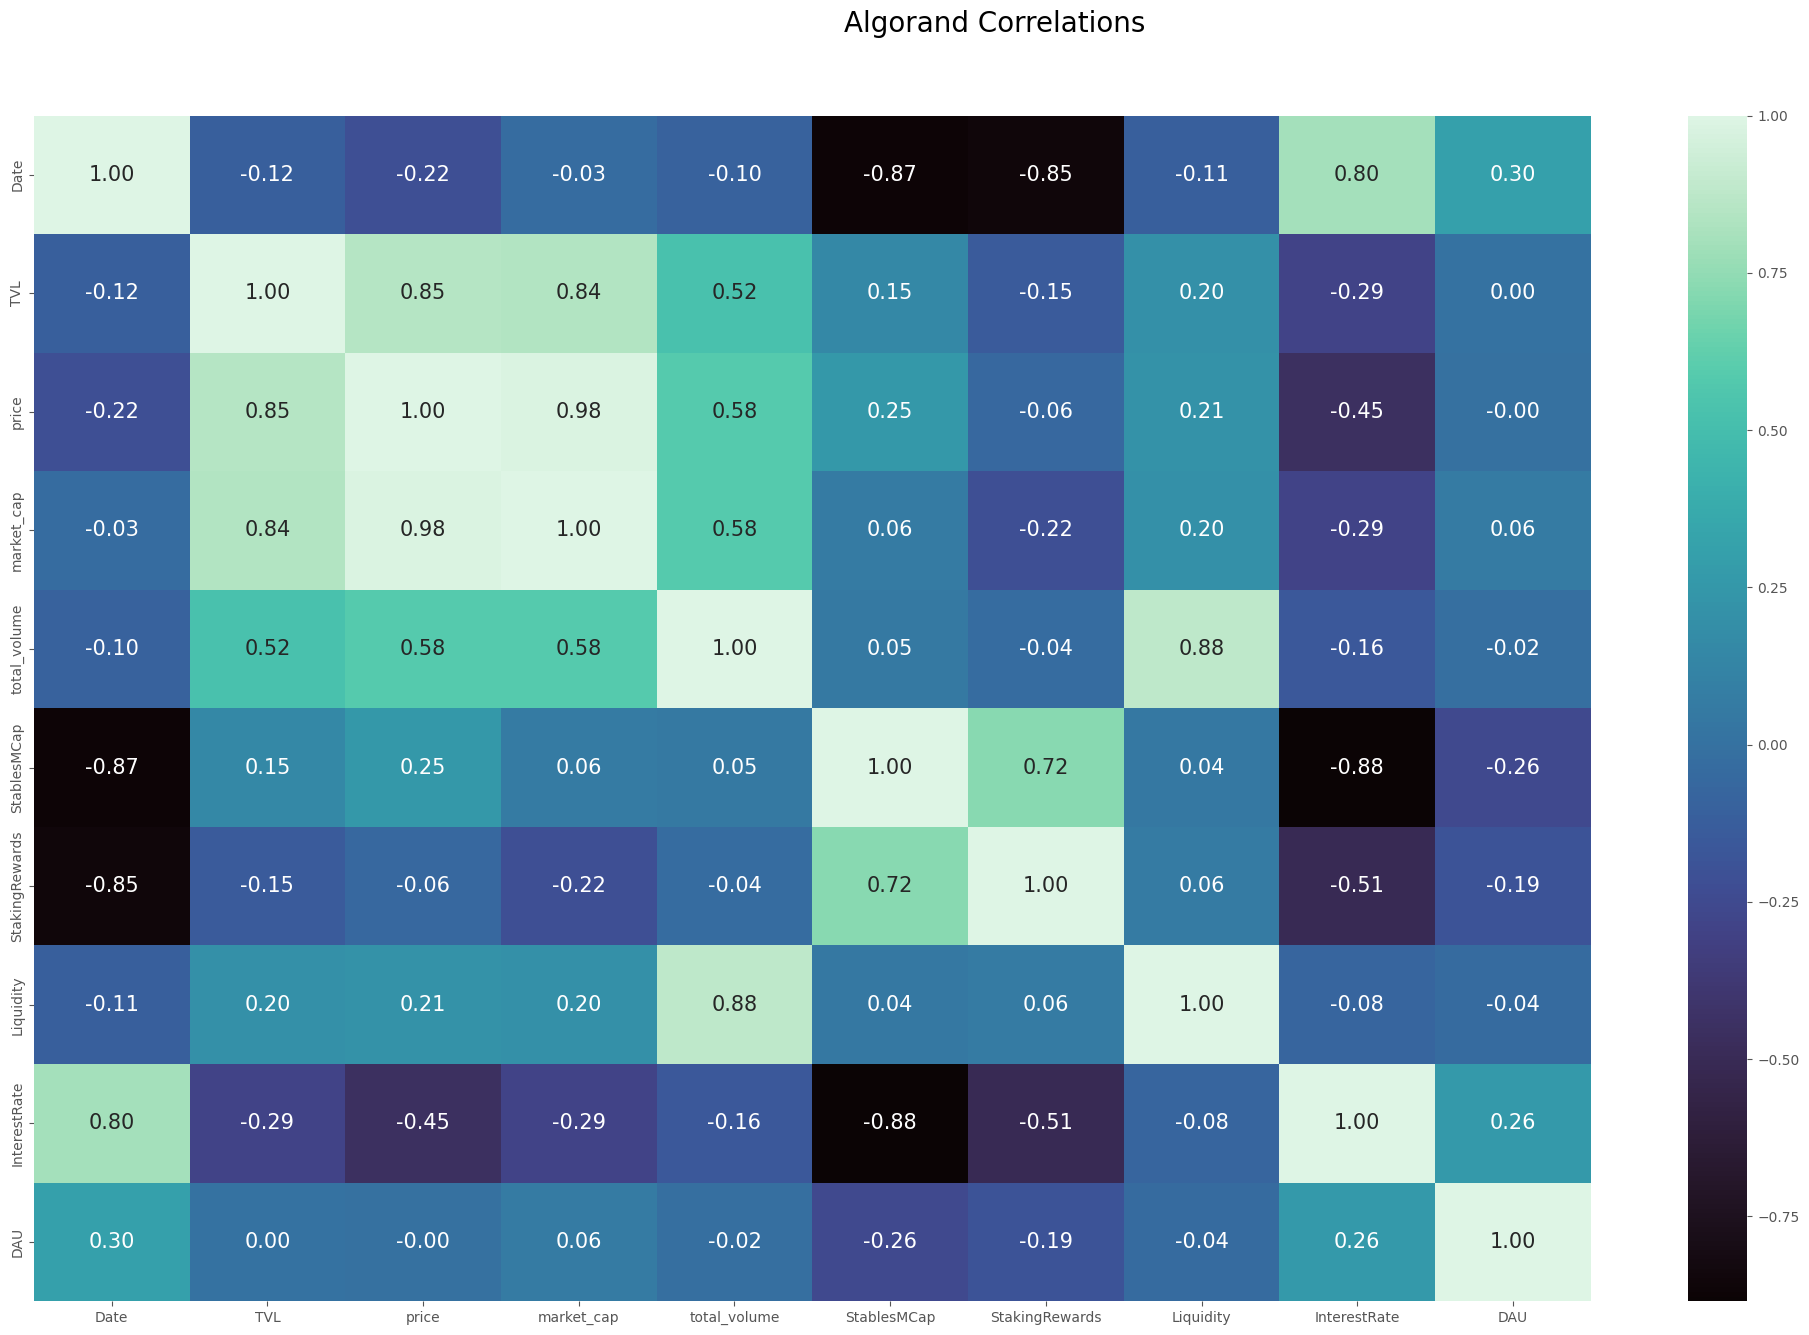

In [62]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 14))  # Slightly larger size for better readability

# Flatten the axes array for easier iteration

sns.heatmap(algorand.corr(), annot=True, cmap='mako', annot_kws={"size": 15}, fmt='.2f')


fig.suptitle('Algorand Correlations', fontsize=20)  # Increase the main title size
# Adjust the layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Add some margin for the suptitle
plt.show()